In [3]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits
import HERA_MapMaking_VisibilitySimulation as mmvs
from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [4]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../simulate_visibilities/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [5]:
len(sys.argv)

3

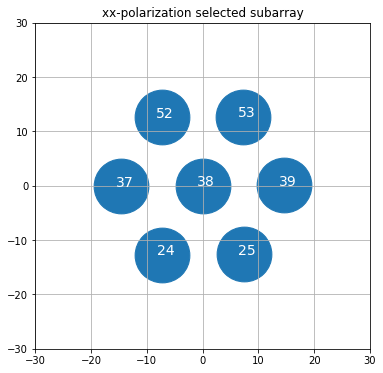

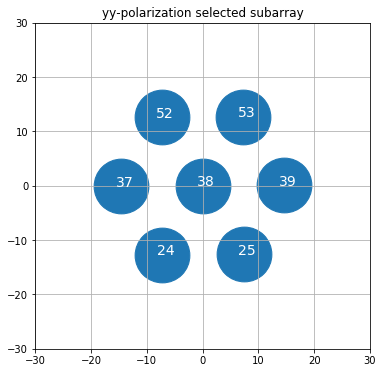

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [6]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = True # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_max8I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mant = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(mmvs.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

In [7]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
2


In [1040]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

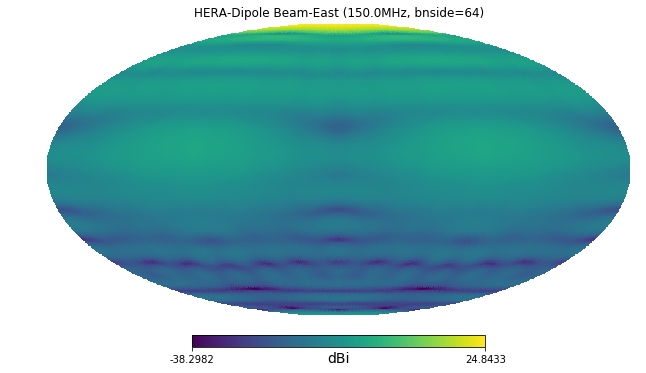

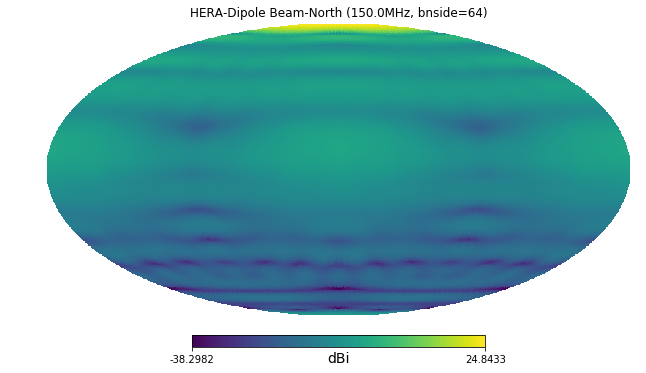

In [1041]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [1042]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


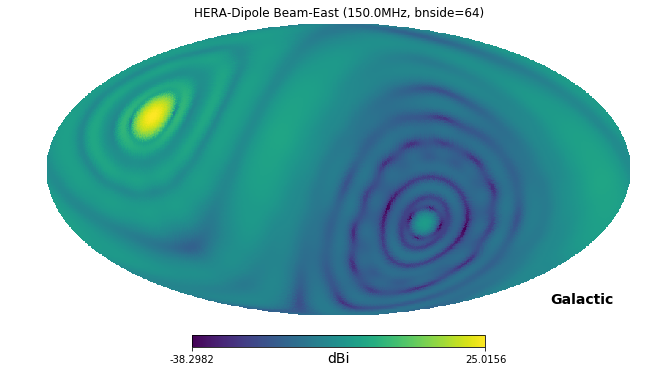

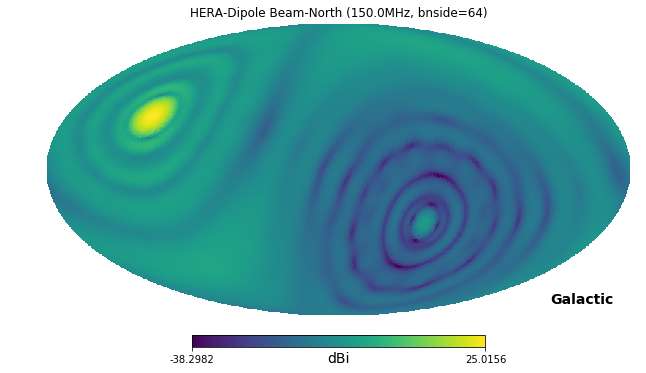

In [1043]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


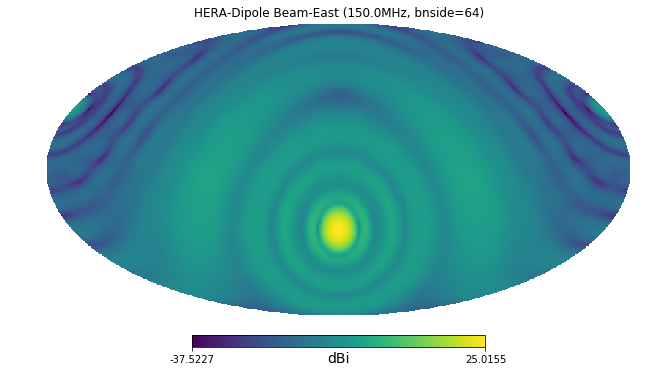

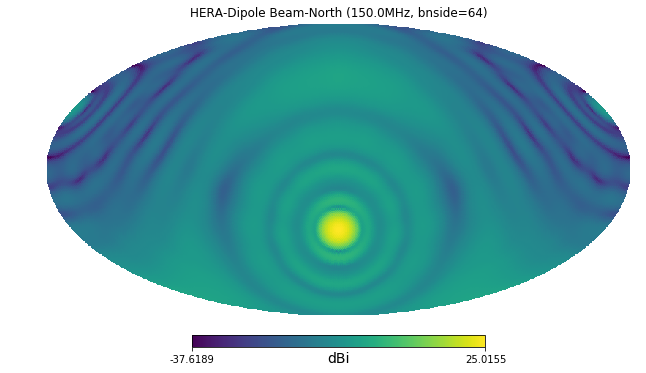

In [1044]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

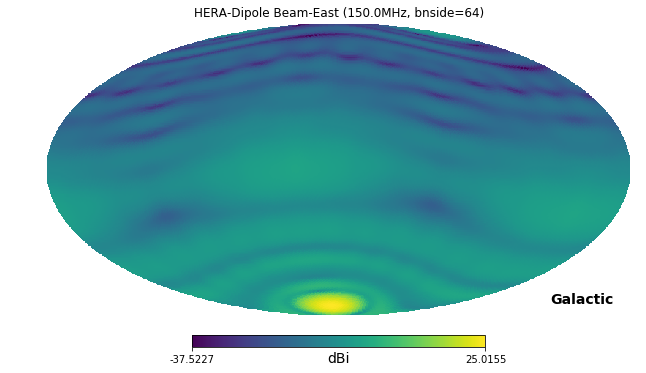

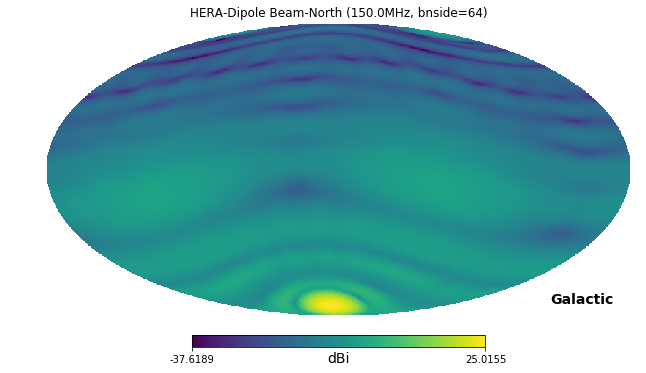

In [1045]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [1046]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [1047]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [1048]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [1049]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [1050]:
#print A.shape

In [1051]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [1052]:
print autocorr_vis.mean()
print fullsim_vis.mean()

1227565.6587779154
(1556.6106039729052-329.7816353772341j)


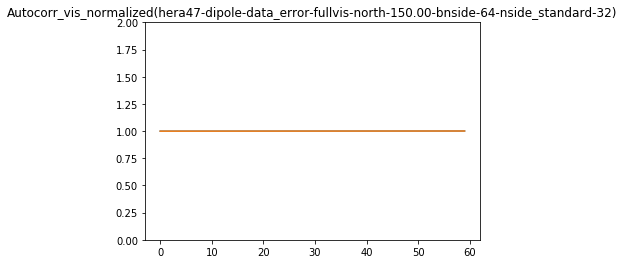

In [1053]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [1054]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [1055]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [1056]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25


In [1057]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


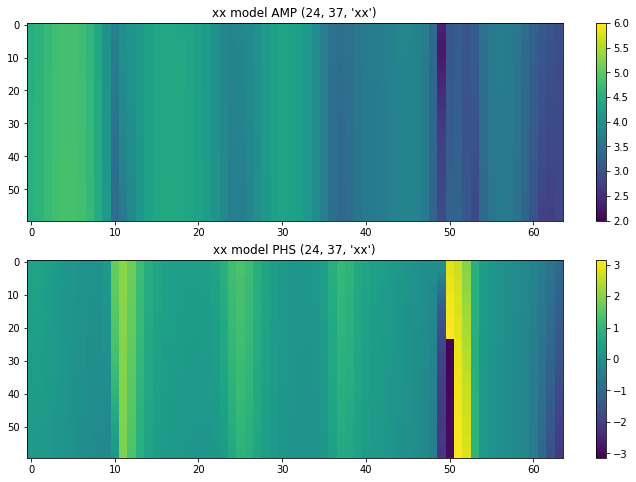

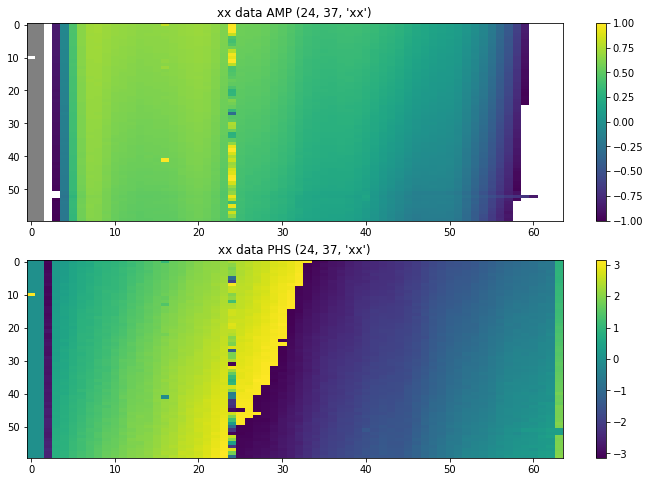

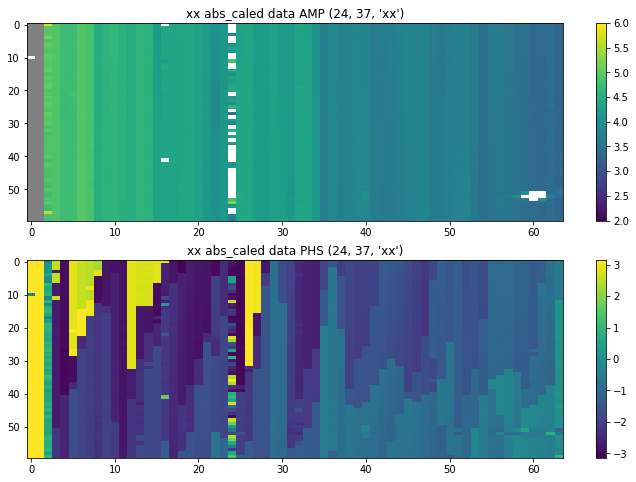

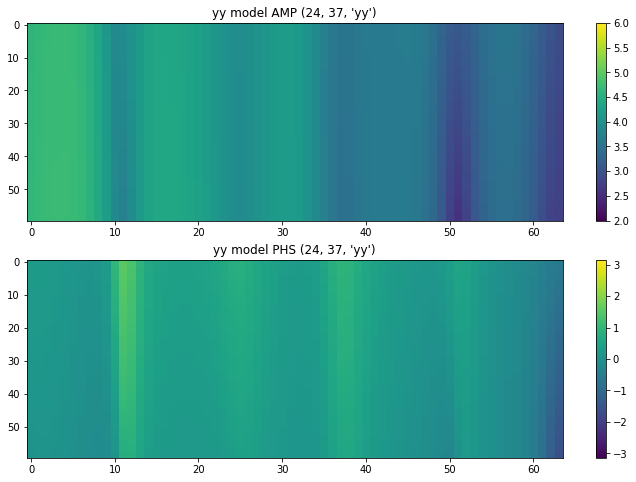

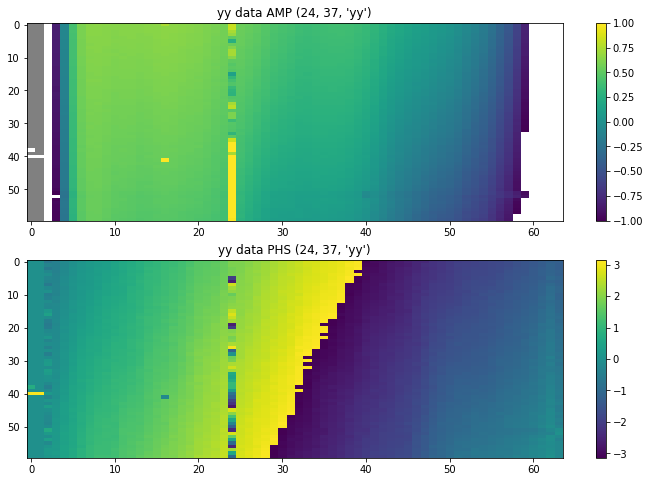

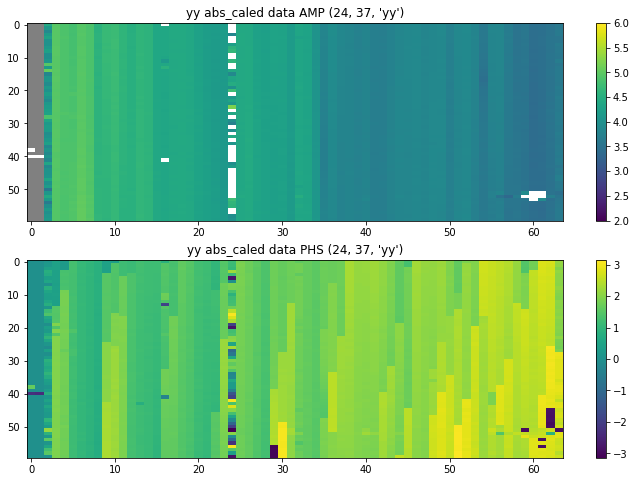

In [1058]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [1059]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [1060]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [1061]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		cal_lst_range = np.array([5, 6]) / TPI * 24.
		calibrate_ubl_length = 1600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		#cal_ubl_mask = {}
		
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		cal_sources = ['cyg', 'cas']
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-08 02:51:02.720688, expected time 0.0 min 6 UBLs to include
6 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00068764  0.00045815] [0.00461413 0.02801072] 1.3767966652334904
2 [-0.00137528  0.0009163 ] [-0.17368097 -0.21120345] 1.3767989954443292
3 [-0.00206292  0.00137445] [ 0.07011991 -0.19873594] 1.3767954839437593
4 [-0.00275056  0.0018326 ] [0.2435305  0.04793892] 1.3767881764918797
5 [-0.00343819  0.00229075] [0.48974445 0.05427915] 1.3767922481531538
6 [-0.00412583  0.0027489 ] [0.66499518 0.29896506] 1.3767862149318708
7 [-0.00481347  0.00320705] [0.48381323 0.05505645] 1.376792832022692
8 [-0.00550111  0.0036652 ] [0.66046859 0.29950871] 1.376786019059579
9 [-0.00618875  0.00412335] [0.48029824 0.05547916] 1.376793306915101
10 [-0.00687639  0.0045815 ] [0.657822   0.29985961] 1.3767860321492902
11 [-0.00756403  0.00503965] [0.47823203 0.05572534] 1.3767935999300631
12 [-0.00825167  0.0054978 ] [0.65627595 0.30007684]

19 [-0.01222485  0.01183238] [-0.00964915 -0.01141212] 0.5213280255493008
20 [-0.01286827  0.01245513] [-0.01015918 -0.01194793] 0.5213280688602763
21 [-0.01351168  0.01307789] [-0.0106695  -0.01247928] 0.5213281114318102
22 [-0.01415509  0.01370065] [-0.01118012 -0.0130064 ] 0.5213281532117132
23 [-0.01479851  0.0143234 ] [-0.01169105 -0.01352954] 0.521328194150198
24 [-0.01544192  0.01494616] [-0.01220231 -0.01404892] 0.52132823419976
25 [-0.01608533  0.01556892] [-0.01271394 -0.01456475] 0.5213282733145098
26 [-0.01672875  0.01619167] [-0.01322594 -0.01507725] 0.5213283114502341
27 [-0.01737216  0.01681443] [-0.01373835 -0.01558667] 0.5213283485658666
28 [-0.01801557  0.01743719] [-0.01425119 -0.01609322] 0.5213283846222
29 [-0.01865899  0.01805994] [-0.01476452 -0.01659713] 0.521328419581794
30 [-0.0193024  0.0186827] [-0.01527835 -0.01709865] 0.5213284534088872
31 [-0.01994581  0.01930546] [-0.01579274 -0.01759799] 0.5213284860693113
32 [-0.02058923  0.01992821] [-0.01630775 -0.01

31 [-0.04707824 -0.02137005] [ 0.02618924 -0.17220084] 73.40217206903786
32 [-0.0490625  -0.02136186] [ 0.02606183 -0.17224469] 73.39460507870565
33 [-0.04729601 -0.02127911] [ 0.02628199 -0.17219597] 73.40148076239107
34 [-0.04937422 -0.02169374] [ 0.02638158 -0.17269542] 73.39567369432204
35 [-0.04769835 -0.02164823] [ 0.02624547 -0.17225008] 73.40164078513284
36 [-0.04963803 -0.02186534] [ 0.02631699 -0.17266762] 73.39635165789258
37 [-0.04707934 -0.02137038] [ 0.0261892 -0.1722012] 73.40217028212305
38 [-0.04906275 -0.02136275] [ 0.02606173 -0.17224476] 73.39460821619116
39 [-0.04729713 -0.02127986] [ 0.02628195 -0.1721961 ] 73.40147996313765
40 [-0.04937531 -0.0216952 ] [ 0.02638141 -0.1726953 ] 73.39567623823605
41 [-0.04769899 -0.0216482 ] [ 0.02624536 -0.17225   ] 73.40164179422567
42 [-0.04963785 -0.02186541] [ 0.02631682 -0.1726675 ] 73.39635413572921
43 [-0.04707973 -0.0213705 ] [ 0.02618917 -0.17220133] 73.40216964941415
44 [-0.04906284 -0.02136307] [ 0.02606168 -0.17224479

17 [-0.00990489  0.00781024] [0.00324878 0.00958601] 69746.1299096397
18 [-0.01055032  0.00832769] [0.00343556 0.01014061] 70025.1750325971
19 [-0.01119807  0.00884874] [0.0036215  0.01069466] 70305.39610863545
20 [-0.01184769  0.00937311] [0.00380662 0.01124814] 70588.21724276702
21 [-0.01249826  0.00990024] [0.00399069 0.0118014 ] 70873.57917134278
22 [-0.01314825  0.01042937] [0.00417368 0.01235452] 71162.24614982451
23 [-0.01379714  0.01096026] [0.00435558 0.01290744] 71454.30308696558
24 [-0.01444448  0.01149264] [0.00453641 0.01346015] 71749.62023661348
25 [-0.01508986  0.01202621] [0.00471619 0.01401261] 72048.0651590568
26 [-0.01573284  0.01256068] [0.00489513 0.01456443] 72349.50051950125
27 [-0.01637251  0.01309488] [0.00507334 0.0151154 ] 72652.9529434854
28 [-0.01700821  0.01362812] [0.00525082 0.0156655 ] 72957.85314773156
29 [-0.01763956  0.01416012] [0.00542759 0.01621472] 73264.07133924117
30 [-0.01826617  0.01469062] [0.00560389 0.01676259] 73571.490469148
31 [-0.01888

30 [-0.05106995 -0.03010335] [-0.04743689 -0.00908433] 39929.9664666274
31 [-0.05266746 -0.03115451] [-0.04848124 -0.00974196] 39817.665209862054
32 [-0.05424781 -0.03219935] [-0.04950697 -0.01040815] 39716.20408781429
33 [-0.05581131 -0.03323743] [-0.05051482 -0.01108248] 39625.50183258917
34 [-0.05735988 -0.03426833] [-0.05150537 -0.01176473] 39545.42907270543
35 [-0.05889382 -0.03529169] [-0.05247936 -0.01245433] 39475.649375576475
36 [-0.06041339 -0.03630719] [-0.05343748 -0.01315077] 39416.0383295498
37 [-0.06191887 -0.03731452] [-0.05438036 -0.01385354] 39366.45455133174
38 [-0.06341053 -0.03831341] [-0.0553086  -0.01456218] 39326.733666232314
39 [-0.06488863 -0.0393036 ] [-0.05622274 -0.01527624] 39296.69095036801
40 [-0.06635341 -0.04028488] [-0.05712331 -0.01599531] 39276.125274814534
41 [-0.06780512 -0.04125707] [-0.05801078 -0.01671897] 39264.819972730096
42 [-0.06924397 -0.04221999] [-0.05888705 -0.01744602] 39262.54382466099
43 [-0.07067016 -0.04317353] [-0.05975908 -0.018

43 [ 0.02479159 -0.07851474] [-0.03119381 -0.03239232] 59051.59712448317
44 [ 0.02505939 -0.08017742] [-0.03184482 -0.03311588] 59488.614194461814
45 [ 0.02532134 -0.0818376 ] [-0.03249452 -0.03383781] 59966.876603554294
46 [ 0.02557758 -0.0834954 ] [-0.03314293 -0.03455807] 60483.1518672807
47 [ 0.02582826 -0.08515096] [-0.03379008 -0.03527663] 61034.159865401976
48 [ 0.02607349 -0.08680439] [-0.03443596 -0.03599342] 61616.633975172794
49 [ 0.02631331 -0.08845584] [-0.03508059 -0.03670841] 62227.345292745296
50 [ 0.02654719 -0.09010579] [-0.03572398 -0.03742154] 62863.103852574204
51 [ 0.02677523 -0.09175436] [-0.03636511 -0.03813216] 63520.63850775348
52 [ 0.0269942  -0.09340351] [-0.03700383 -0.03884012] 64196.89907016564
53 [ 0.02720321 -0.09505361] [-0.03764011 -0.03954534] 64887.952213338926
54 [ 0.02740645 -0.09670238] [-0.03827392 -0.04024775] 65590.45933548121
55 [ 0.02760463 -0.09834954] [-0.03890522 -0.04094726] 66302.92395573837
56 [ 0.02779312 -0.09999744] [-0.03953398 -0.

54 [ 0.02260365 -0.06098669] [ 0.0021564  -0.08460004] 35619.98507574606
55 [ 0.02260342 -0.06147572] [ 0.00223328 -0.0858665 ] 35617.37101517295
56 [ 0.02259591 -0.06195615] [ 0.00230814 -0.08712207] 35616.31782437412
57 [ 0.02258153 -0.06242832] [ 0.00238078 -0.08836654] 35616.72545729197
58 [ 0.02256066 -0.06289255] [ 0.00245012 -0.08959817] 35618.52390859238
59 [ 0.02253364 -0.06334919] [ 0.00251603 -0.09081692] 35621.66350671003
60 [ 0.0225013  -0.06379932] [ 0.0025784  -0.09202275] 35626.07691361617
61 [ 0.02246408 -0.06424347] [ 0.00263541 -0.09321269] 35631.68541700766
62 [ 0.02242225 -0.06468187] [ 0.00268689 -0.09438666] 35638.44871430257
63 [ 0.02237607 -0.0651147 ] [ 0.00273294 -0.09554459] 35646.30461193598
64 [ 0.02232577 -0.06554217] [ 0.00277551 -0.096689  ] 35655.18854642221
65 [ 0.02227159 -0.06596445] [ 0.002816   -0.09782245] 35665.01543995189
66 [ 0.02221375 -0.06638171] [ 0.00285549 -0.09894688] 35675.7199367642
67 [ 0.02215247 -0.06679413] [ 0.0028937  -0.1000618

70 [ 0.06162217 -0.07960204] [0.07114434 0.04546765] 43506.951596582025
71 [ 0.06406185 -0.07900783] [0.07263489 0.04841498] 43520.21983944455
72 [ 0.09177596 -0.06636652] [0.07675583 0.05282417] 43530.79362325979
73 [ 0.09679699 -0.07117019] [0.07331866 0.05717633] 43273.54464188553
74 [ 0.10243178 -0.07619188] [0.06995157 0.06145083] 43217.54678239938
75 [ 0.10786698 -0.08124725] [0.06641157 0.06567098] 43177.142759891045
76 [ 0.11316952 -0.0866479 ] [0.06219976 0.06994718] 43179.016287539605
77 [ 0.11876227 -0.09315086] [0.05638527 0.0744402 ] 43228.14624320671
78 [ 0.12516303 -0.10169987] [0.03599298 0.07930195] 43324.214000058004
79 [ 0.13370019 -0.11563444] [0.01221647 0.08308393] 43458.07577674994
80 [ 0.13751534 -0.12728164] [-0.00721586  0.08690484] 43480.33091432252
81 [ 0.14217651 -0.13448742] [-0.02261835  0.09265346] 43387.527705581044
82 [ 0.14541879 -0.13989386] [-0.03158126  0.09709796] 43256.72028457652
83 [ 0.14765905 -0.14488253] [-0.03829305  0.10080402] 43211.94252

82 [-0.12397202  0.09519184] [ 0.07890578 -0.0725817 ] 56638.53025086731
83 [-0.1239734   0.09518758] [ 0.07881019 -0.07286019] 56639.15189616752
84 [-0.12397452  0.0951838 ] [ 0.07871411 -0.07312904] 56639.794906917836
85 [-0.12397541  0.09518044] [ 0.07861848 -0.07338886] 56640.4451932808
86 [-0.12397611  0.09517745] [ 0.07852391 -0.07364012] 56641.09210641007
87 [-0.12397665  0.0951748 ] [ 0.07843084 -0.07388321] 56641.72901767733
88 [-0.12397705  0.09517245] [ 0.07833956 -0.07411847] 56642.35173925829
89 [-0.12397734  0.09517037] [ 0.07825029 -0.07434621] 56642.95741927754
90 [-0.12397753  0.09516853] [ 0.07816317 -0.0745667 ] 56643.544371217286
91 [-0.12397764  0.0951669 ] [ 0.07807829 -0.07478021] 56644.11151143979
92 [-0.12397767  0.09516547] [ 0.07799569 -0.07498694] 56644.658426887814
93 [-0.12397765  0.0951642 ] [ 0.07791538 -0.07518711] 56645.18536015344
94 [-0.12397758  0.09516309] [ 0.07783738 -0.07538092] 56645.69256758816
95 [-0.12397747  0.09516211] [ 0.07773653 -0.0755

93 [0.00428821 0.09242089] [-0.05940714 -0.1517624 ] 57933.7651393657
94 [0.00457332 0.09327476] [-0.0604021  -0.15295651] 58180.577308633394
95 [0.0048628  0.09412628] [-0.06141632 -0.15414004] 58428.12266770923
96 [0.00515616 0.09497537] [-0.06245354 -0.15530882] 58676.51568119655
97 [0.00545233 0.09582195] [-0.06350548 -0.15646463] 58925.729472966836
98 [0.00575071 0.09666593] [-0.06456061 -0.15760857] 59175.015278631225
99 [0.00605238 0.0975072 ] [-0.06563105 -0.1587403 ] 59423.0110126722
100 [0.00635752 0.09834566] [-0.06672306 -0.15985954] 59670.95846661984
((126.2814461665853+0j), 115.625, array([0.00635752, 0.09834566]), 115.625, array([-0.06672306, -0.15985954]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00188266 -0.00178049] [0.00026785 0.00170449] 57530.5002993523
2 [-0.00379251 -0.00353421] [0.000628   0.00344172] 57341.653038793724
3 [-0.00569378 -0.00527472] [0.00107051 0.00519064] 57150.31298064064
4 [-0.00759533 -0.0069949 ]

6 [-0.04969403 -0.00266744] [-0.0146065  -0.01844587] 175500.6726881586
7 [-0.05275078 -0.00380742] [-0.01597352 -0.02033448] 175201.75393319994
8 [-0.05512407 -0.00503438] [-0.01716052 -0.02191707] 174903.97961672003
9 [-0.05709498 -0.0062492 ] [-0.0181507  -0.02319525] 174634.49347234098
10 [-0.05879566 -0.00743083] [-0.01897046 -0.0242816 ] 174398.44472689676
11 [-0.06027291 -0.0085742 ] [-0.01971095 -0.02518445] 174179.56215466838
12 [-0.06144935 -0.00968609] [-0.02031071 -0.0260226 ] 173988.32844946272
13 [-0.06247239 -0.01075795] [-0.02082929 -0.0267932 ] 173796.8916365018
14 [-0.06346265 -0.01178641] [-0.02134199 -0.02740991] 173610.30832793703
15 [-0.0643342  -0.01277664] [-0.02175234 -0.02799604] 173455.80552762025
16 [-0.06511185 -0.01372202] [-0.0221047  -0.02854836] 173297.34235815803
17 [-0.06587295 -0.01462067] [-0.02242075 -0.02906681] 173140.65340039585
18 [-0.0666538  -0.01547671] [-0.02271105 -0.02955167] 172986.69609268522
19 [-0.06737633 -0.01629556] [-0.02298358 -0

16 [0.04328571 0.00383229] [0.13141797 0.2053711 ] 58100.08838914414
17 [0.04337354 0.00337454] [0.13553179 0.20359468] 57903.91434419466
18 [0.04344776 0.00292546] [0.13955259 0.20171256] 57773.69290885591
19 [0.04351255 0.00248093] [0.14337979 0.1997623 ] 57716.63147659308
20 [0.04357204 0.00203679] [0.14698146 0.19775933] 57736.67126928936
21 [0.04363012 0.00158906] [0.15035653 0.19570637] 57831.63953453244
22 [0.04369033 0.00113383] [0.15350147 0.19361395] 57997.23978416167
23 [0.04375592 0.00066731] [0.15640754 0.19150336] 58227.24552067732
24 [0.04382959 0.00018567] [0.15910932 0.189357  ] 58512.570445722406
25 [ 0.04391458 -0.00031373] [0.16159526 0.18719189] 58848.328897461986
26 [ 0.04401305 -0.00083457] [0.16390489 0.18496599] 59224.65741140754
27 [ 0.04412774 -0.00138028] [0.16613477 0.1826753 ] 59641.41214418306
28 [ 0.04426137 -0.00195568] [0.16828077 0.18035338] 60100.72640815209
29 [ 0.04441701 -0.00256444] [0.17026591 0.17798624] 60592.871387417064
30 [ 0.04459827 -0.00

31 [-0.13173824 -0.01162379] [-0.04015567 -0.03262245] 51064.451824798176
32 [-0.13358977 -0.01325135] [-0.04058499 -0.03334866] 50971.81912818786
33 [-0.13543701 -0.01486669] [-0.04103641 -0.03406953] 50881.44911403026
34 [-0.1372222  -0.01647002] [-0.04150301 -0.03479257] 50793.246498263696
35 [-0.13895948 -0.01806137] [-0.04197439 -0.03551477] 50706.09293271494
36 [-0.14058191 -0.01963985] [-0.04245817 -0.03623672] 50620.01629242085
37 [-0.14215171 -0.0212012 ] [-0.04295658 -0.03695501] 50533.29165109007
38 [-0.14367489 -0.0227441 ] [-0.04349087 -0.03766896] 50447.46349741092
39 [-0.14516362 -0.02426758] [-0.04402451 -0.03838269] 50362.86548938691
40 [-0.14654681 -0.02577089] [-0.04452709 -0.03909696] 50279.56433250422
41 [-0.14788041 -0.02725119] [-0.04500202 -0.03981463] 50194.98350471871
42 [-0.14922981 -0.02870832] [-0.04545669 -0.04053299] 50110.94564259463
43 [-0.15051519 -0.03014576] [-0.04590725 -0.04124698] 50029.87767479615
44 [-0.15175973 -0.03156379] [-0.0463521  -0.0419

42 [ 0.03589283 -0.27657374] [-0.05139528 -0.38647213] 33894.95799610833
43 [ 0.03673706 -0.27693985] [-0.05115136 -0.38766184] 33936.559662562526
44 [ 0.03718386 -0.27736162] [-0.05057335 -0.38844123] 33975.28178542407
45 [ 0.03743539 -0.2777294 ] [-0.0501297  -0.38919156] 33999.460407070685
46 [ 0.03785698 -0.27819088] [-0.04977371 -0.38980827] 34021.2893962666
47 [ 0.03805611 -0.27865605] [-0.04948714 -0.39015198] 34040.515210916
48 [ 0.03796994 -0.27924743] [-0.04928201 -0.39044895] 34052.07712382217
49 [ 0.03790244 -0.27978086] [-0.04909756 -0.39069218] 34062.46302335391
50 [ 0.03783579 -0.28069968] [-0.04894673 -0.39091184] 34071.07328304818
51 [ 0.03773901 -0.28175574] [-0.04877403 -0.391142  ] 34081.5494680998
52 [ 0.03748185 -0.28239692] [-0.04853111 -0.39147752] 34092.63193365884
53 [ 0.03741907 -0.28306909] [-0.0483522  -0.39174654] 34102.464349266535
54 [ 0.03749532 -0.28358872] [-0.04818713 -0.39209494] 34111.43197086391
55 [ 0.03773614 -0.28426228] [-0.04810587 -0.3923950

54 [-0.16584208 -0.19362178] [-0.11356111 -0.23271212] 49077.266953462706
55 [-0.16784924 -0.19567319] [-0.11548143 -0.23473505] 49087.54361145466
56 [-0.16977078 -0.19777128] [-0.1174507 -0.236329 ] 49100.49403288628
57 [-0.17187927 -0.19989524] [-0.11994924 -0.23694266] 49115.74914029634
58 [-0.17436804 -0.20165433] [-0.12136625 -0.2377762 ] 49141.66347018808
59 [-0.19334026 -0.20357409] [-0.12230064 -0.23853552] 49155.1919844141
60 [ 0.01354464 -0.08446266] [-0.12074298 -0.24176948] 49199.03978623701
61 [ 0.00400659 -0.07845451] [-0.12309811 -0.24008136] 49180.896790018814
62 [ 0.00070988 -0.07980452] [-0.12090524 -0.24324982] 49207.86717860662
63 [-0.00112333 -0.07712384] [-0.12420759 -0.24118858] 49188.80512077435
64 [-0.00221325 -0.08268776] [-0.12080563 -0.24444835] 49211.87677733608
65 [-0.00378354 -0.07996515] [-0.12435572 -0.24179225] 49184.25040293611
66 [-0.004308   -0.08315121] [-0.12093348 -0.2448041 ] 49211.331963780154
67 [-0.00544347 -0.08101029] [-0.12449383 -0.242078

66 [ 0.06540917 -0.05033644] [0.01692233 0.05987059] 72915.44844852042
67 [ 0.06543095 -0.05033007] [0.01693099 0.05987978] 72915.29818652374
68 [ 0.06545001 -0.05032225] [0.01693907 0.05988834] 72915.20123847219
69 [ 0.06546698 -0.05031364] [0.01694656 0.05989632] 72915.14238351233
70 [ 0.0654823  -0.05030466] [0.01695352 0.05990374] 72915.11084658759
71 [ 0.06549628 -0.05029561] [0.01695995 0.05991065] 72915.09896296417
72 [ 0.06550914 -0.05028667] [0.01696591 0.05991707] 72915.10125298635
73 [ 0.06552112 -0.05027793] [0.01697141 0.05992304] 72915.11377791075
74 [ 0.06553241 -0.0502694 ] [0.01697649 0.05992857] 72915.13431123052
75 [ 0.0655431  -0.05026113] [0.01698119 0.05993371] 72915.1617369717
76 [ 0.06555324 -0.05025315] [0.01698552 0.05993846] 72915.19452485749
77 [ 0.06556288 -0.05024547] [0.01698951 0.05994287] 72915.2315036568
78 [ 0.06557205 -0.05023809] [0.01699319 0.05994695] 72915.2717640897
79 [ 0.06558079 -0.05023101] [0.01699658 0.05995072] 72915.31458979088
80 [ 0.06

97 [0.03877111 0.0438406 ] [-0.0200469  -0.11478681] 49064.54006556093
98 [0.03876921 0.04384032] [-0.02006101 -0.1148117 ] 49064.38907838463
99 [0.03876745 0.04384008] [-0.02007427 -0.11483487] 49064.249174306344
100 [0.03876583 0.04383985] [-0.02008669 -0.11485643] 49064.11934946605
((-180.83251861498894-0j), 128.125, array([0.03876583, 0.04383985]), 128.125, array([-0.02008669, -0.11485643]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00869879  0.00874076] [-0.00994364  0.00198309] 62045.98177955858
2 [-0.0153126   0.01722604] [-0.01637128  0.00250809] 61530.451848253106
3 [-0.0203013   0.02500706] [-0.02153967  0.00271195] 61035.27949584617
4 [-0.0241502   0.03214185] [-0.02585938  0.00270716] 60606.060032079535
5 [-0.02731439  0.03865318] [-0.02960926  0.00257688] 60252.476189446876
6 [-0.02990847  0.04461529] [-0.03290622  0.00237266] 59968.401393048975
7 [-0.03196986  0.05008318] [-0.03587709  0.00212471] 59750.10680491393
8 [-0.03358

4 [ 0.02582925 -0.01192597] [ 0.0135258  -0.00767894] 43388.53459054626
5 [ 0.02834828 -0.01283247] [ 0.0157001  -0.00846161] 43323.59038074046
6 [ 0.03043725 -0.01356571] [ 0.01786129 -0.0091494 ] 43259.497430324336
7 [ 0.03210598 -0.01418377] [ 0.01998541 -0.00973605] 43200.132369754014
8 [ 0.03353911 -0.01468921] [ 0.02237935 -0.01041674] 43143.70978762462
9 [ 0.03475502 -0.01510452] [ 0.02463525 -0.01095171] 43080.26622843544
10 [ 0.03578049 -0.01544427] [ 0.02678883 -0.01139815] 43019.463289058476
11 [ 0.03669    -0.01572586] [ 0.02883471 -0.01174335] 42960.14911431628
12 [ 0.03750256 -0.01594909] [ 0.03076864 -0.01199003] 42902.34717478258
13 [ 0.03822753 -0.01611582] [ 0.03261934 -0.01217363] 42845.970007167525
14 [ 0.03883312 -0.01621471] [ 0.03436759 -0.01227541] 42790.27501235694
15 [ 0.03938548 -0.01628335] [ 0.03601258 -0.01227895] 42734.87413993184
16 [ 0.03988615 -0.0163274 ] [ 0.03756569 -0.01221599] 42680.48995132136
17 [ 0.04031173 -0.01634768] [ 0.03898717 -0.01206532

15 [-0.01177025 -0.00122179] [-0.00524379  0.00999929] 27479.15177587382
16 [-0.0124792  -0.00123662] [-0.00543581  0.01054027] 27506.795463653234
17 [-0.01316614 -0.0012437 ] [-0.00560188  0.01106864] 27533.22035064017
18 [-0.01382462 -0.00123675] [-0.00575245  0.01158594] 27558.38498571593
19 [-0.01446776 -0.0012107 ] [-0.00587778  0.01209206] 27582.34409944747
20 [-0.01509575 -0.0011656 ] [-0.00598386  0.01258495] 27605.126625395817
21 [-0.01572734 -0.00109496] [-0.00607168  0.01306527] 27626.90821300827
22 [-0.01636074 -0.00100756] [-0.00614581  0.01353573] 27648.182829155587
23 [-0.01698328 -0.0009022 ] [-0.00620232  0.01399308] 27669.144167725342
24 [-0.01761461 -0.00075714] [-0.00624497  0.01443642] 27689.333743589064
25 [-0.018257   -0.00058644] [-0.00627826  0.01486432] 27709.25349908921
26 [-0.01891212 -0.00038637] [-0.0063029  0.0152775] 27729.222073531186
27 [-0.01958066 -0.00015863] [-0.00631975  0.01567623] 27749.322845032944
28 [-2.02491415e-02  7.28298152e-05] [-0.00642

27 [0.00644106 0.02963423] [ 0.02100666 -0.01284572] 29482.36459245372
28 [0.00674764 0.0305688 ] [ 0.02152557 -0.01334555] 29397.946929740894
29 [0.00705538 0.03149527] [ 0.02203072 -0.0138469 ] 29318.312652482782
30 [0.00736419 0.03241375] [ 0.0225218  -0.01434849] 29243.24207766175
31 [0.00767394 0.03332432] [ 0.02300636 -0.01485424] 29172.59811300998
32 [0.00798462 0.03422723] [ 0.02348921 -0.01536792] 29106.532105247403
33 [0.00829629 0.0351228 ] [ 0.02396714 -0.01588645] 29045.219309194166
34 [0.00860871 0.03601091] [ 0.02445203 -0.01641706] 28988.475446765988
35 [0.00892176 0.03689195] [ 0.02492991 -0.01695286] 28936.82036941403
36 [0.00923558 0.03776633] [ 0.0253926  -0.01748795] 28889.677903660126
37 [0.00955011 0.03863417] [ 0.02584026 -0.018022  ] 28846.524857442215
38 [0.00986514 0.03949542] [ 0.02627593 -0.01855669] 28807.224619817065
39 [0.01018164 0.04035067] [ 0.02670032 -0.01909252] 28771.813018176956
40 [0.01049919 0.0412    ] [ 0.02712224 -0.01963451] 28740.306858594

43 [ 0.01518436 -0.01329583] [-0.0165106   0.00201878] 40450.45291925763
44 [ 0.01552886 -0.01367327] [-0.01683221  0.00208853] 40618.40938610011
45 [ 0.01586138 -0.01404542] [-0.01715125  0.00215974] 40785.4767419466
46 [ 0.01619041 -0.01441635] [-0.01746768  0.00223235] 40951.2759924704
47 [ 0.01651724 -0.01478764] [-0.01778164  0.00230661] 41117.0397093439
48 [ 0.01684136 -0.01516059] [-0.01809333  0.00238283] 41283.01961508908
49 [ 0.01715301 -0.01552994] [-0.01840275  0.00246102] 41449.24370718192
50 [ 0.01745944 -0.01590019] [-0.01870988  0.00254117] 41614.0451729627
51 [ 0.01776284 -0.01627211] [-0.01901475  0.00262331] 41778.55858916288
52 [ 0.01806342 -0.01664558] [-0.01931746  0.00270663] 41943.06207257476
53 [ 0.01835643 -0.0170175 ] [-0.01961803  0.00279048] 42107.44197885864
54 [ 0.01864097 -0.01738762] [-0.01991646  0.00287485] 42270.73025019611
55 [ 0.01892263 -0.01775849] [-0.02021265  0.00295977] 42432.723881508675
56 [ 0.01920096 -0.01812862] [-0.02050641  0.0030448 ]

53 [ 0.03514892 -0.0561681 ] [-0.19067809 -0.31806957] 255475.34136824904
54 [ 0.03517227 -0.0562406 ] [-0.19069022 -0.31807259] 255476.7494723846
55 [ 0.03518626 -0.05629801] [-0.19070298 -0.31807509] 255477.96850267667
56 [ 0.03519377 -0.05634436] [-0.19071555 -0.31807718] 255479.02876196415
57 [ 0.03519723 -0.05638187] [-0.19072753 -0.31807893] 255479.96994415912
58 [ 0.03519822 -0.05641227] [-0.19073864 -0.31808039] 255480.78658237675
59 [ 0.03519779 -0.05643696] [-0.19074869 -0.31808161] 255481.4842712017
60 [ 0.03519659 -0.05645703] [-0.19075763 -0.31808263] 255482.07389082704
61 [ 0.03519503 -0.05647337] [-0.19076545 -0.31808347] 255482.5682980589
62 [ 0.03519337 -0.05648668] [-0.1907722  -0.31808417] 255482.98049887954
63 [ 0.03519175 -0.05649753] [-0.19077799 -0.31808474] 255483.3227017689
64 [ 0.03519025 -0.05650639] [-0.1907829  -0.31808521] 255483.60588578708
((-111.31897749540296-0j), 137.5, array([ 0.03519025, -0.05650639]), 137.5, array([-0.1907829 , -0.31808521]))
9 UBL

1 [ 0.00189371 -0.00113786] [0.00064622 0.0012521 ] 66083.20052375559
2 [ 0.0036703  -0.00221271] [0.00124238 0.00250901] 65562.68527579625
3 [ 0.00532341 -0.00323228] [0.00178078 0.00376867] 65103.077619680334
4 [ 0.00688367 -0.00420269] [0.0022798 0.0050277] 64704.7976582907
5 [ 0.00835137 -0.00512796] [0.00273979 0.00628757] 64357.44503102897
6 [ 0.00974768 -0.00601096] [0.00315696 0.00755516] 64058.640001209686
7 [ 0.01106734 -0.00685378] [0.00353335 0.00883047] 63801.32158736712
8 [ 0.01232036 -0.00765881] [0.00387349 0.01011282] 63583.99042387021
9 [ 0.01350224 -0.00842888] [0.00418991 0.01140045] 63401.758142918006
10 [ 0.01462285 -0.00916531] [0.00447441 0.01270008] 63252.371675493305
11 [ 0.0156873  -0.00987178] [0.00472811 0.01400962] 63131.68496129591
12 [ 0.0166893  -0.01055073] [0.00495099 0.01532911] 63036.45777600914
13 [ 0.01763554 -0.01120525] [0.005145   0.01666024] 62965.256451189736
14 [ 0.01852989 -0.0118361 ] [0.00532616 0.01799578] 62914.88582598037
15 [ 0.019376

13 [ 0.01186534 -0.0020811 ] [0.02101985 0.00855009] 33272.113230844014
14 [ 0.01298704 -0.00212147] [0.02278563 0.00927415] 33457.699267812495
15 [ 0.01413422 -0.00210821] [0.02458737 0.01001729] 33630.391177537844
16 [ 0.01532059 -0.0020558 ] [0.02653064 0.01081186] 33799.429757390826
17 [ 0.01656221 -0.00197396] [0.02843964 0.01164376] 33971.31653776178
18 [ 0.01786256 -0.00185196] [0.03028031 0.01251127] 34130.21378212366
19 [ 0.01923487 -0.00168949] [0.03205755 0.01340219] 34273.99159974289
20 [ 0.02068338 -0.00146456] [0.03395445 0.01433424] 34403.57407213167
21 [ 0.02225434 -0.00119443] [0.03590314 0.01534077] 34529.708213849495
22 [ 0.02394185 -0.00084714] [0.03814395 0.01623075] 34646.69436852162
23 [ 0.025716   -0.00039242] [0.0405559  0.01704901] 34762.694819678516
24 [0.02740598 0.0001082 ] [0.04290832 0.01790828] 34867.65408400951
25 [0.02938031 0.00097519] [0.04523313 0.0188282 ] 34950.62648985296
26 [0.03171376 0.00261218] [0.04756235 0.02008053] 35018.036262906084
27 [0

25 [ 0.05591786 -0.0002974 ] [-0.03667616  0.00425911] 45149.54718759047
26 [0.05687219 0.00030122] [-0.03784248  0.00413686] 45170.44064372139
27 [0.0577521  0.00090741] [-0.03912844  0.00405388] 45190.05338541419
28 [0.05856137 0.00151464] [-0.04032628  0.00394883] 45210.271549945894
29 [0.05931013 0.00212921] [-0.04136935  0.00377524] 45228.40677044799
30 [0.05999022 0.00276072] [-0.04226819  0.00354182] 45243.522565544394
31 [0.06060577 0.00339946] [-0.04306092  0.00324881] 45255.66759116263
32 [0.06116606 0.00403764] [-0.04376504  0.00290986] 45265.54274770258
33 [0.06169841 0.00468965] [-0.04442676  0.00251694] 45273.608066819565
34 [0.06220221 0.00534562] [-0.04504825  0.00208527] 45280.60998771228
35 [0.06268659 0.00601314] [-0.04562789  0.00162835] 45286.71663681336
36 [0.06315132 0.0066856 ] [-0.04616247  0.00115875] 45291.98486249375
37 [0.06359623 0.00735884] [-0.04664322  0.00068606] 45296.487970474234
38 [0.06401304 0.0080132 ] [-0.04707692  0.00021014] 45300.19781629645


38 [0.04846892 0.01927318] [ 0.07537762 -0.04643652] 55068.91583551766
39 [0.04860238 0.01937988] [ 0.0752825  -0.04678463] 55071.332632458485
40 [0.0487247  0.01948506] [ 0.07519675 -0.04711925] 55073.34364127791
41 [0.0488371  0.01958737] [ 0.07511864 -0.04744058] 55075.0241607265
42 [0.04894061 0.01968664] [ 0.07504683 -0.04774889] 55076.42564549393
43 [0.04903615 0.01978273] [ 0.07491471 -0.04800856] 55077.59755246823
44 [0.04912389 0.01987564] [ 0.07480412 -0.04826196] 55080.225544919
45 [0.04920478 0.01996513] [ 0.0747101  -0.04850855] 55082.28946267368
46 [0.04927984 0.02005071] [ 0.07462888 -0.04874791] 55083.91170379861
47 [0.04934965 0.02013244] [ 0.07455761 -0.04897978] 55085.192785513034
48 [0.04941471 0.02021043] [ 0.07449418 -0.04920408] 55086.20469926895
49 [0.04947546 0.02028478] [ 0.07443489 -0.04942082] 55087.002395791285
50 [0.04953226 0.02035562] [ 0.07437746 -0.04963017] 55087.662577728675
51 [0.04958527 0.02042321] [ 0.07432187 -0.04983236] 55088.23419609225
52 [0

52 [0.19027101 0.21190799] [-0.06012026  0.06709704] 27192.55307272688
53 [0.19026646 0.21182547] [-0.0600098   0.06768713] 27181.565807391326
54 [0.19026176 0.2117444 ] [-0.05990784  0.06828998] 27170.39959296906
55 [0.19025693 0.2116647 ] [-0.05982114  0.06891064] 27158.820212492257
56 [0.19025197 0.21158626] [-0.05974263  0.06954986] 27146.61889663281
57 [0.19024687 0.211509  ] [-0.05964898  0.07020527] 27133.86089155045
58 [0.19024165 0.21143262] [-0.05952694  0.07087319] 27120.91243847925
59 [0.19023625 0.21135658] [-0.05937251  0.07153199] 27108.045070030486
60 [0.19023074 0.21128094] [-0.05920175  0.07217659] 27095.796797956835
61 [0.19022517 0.21120626] [-0.05901188  0.07281955] 27084.0677906933
62 [0.19021956 0.21113317] [-0.0588092  0.0734685] 27072.651772101075
63 [0.19021394 0.21106164] [-0.05859748  0.07411934] 27061.30820894088
64 [0.19020834 0.21099164] [-0.05837719  0.07475294] 27050.078521489548
65 [0.19020277 0.21092313] [-0.05815325  0.07537623] 27039.38397064399
66 

68 [-0.13004881 -0.01280152] [0.04430163 0.02494807] 48680.31121816947
69 [-0.13010688 -0.01275349] [0.04430754 0.02494923] 48677.20523201782
70 [-0.13013564 -0.01271222] [0.04430385 0.02494908] 48680.122253042566
71 [-0.13006217 -0.01276868] [0.04429515 0.02494701] 48682.49445470937
72 [-0.13011046 -0.01272463] [0.04429793 0.02494729] 48679.03678377885
73 [-0.13004841 -0.01277909] [0.0442931  0.02494563] 48681.69320259132
74 [-0.13010348 -0.01273354] [0.04429814 0.02494632] 48678.41036549309
75 [-0.13004535 -0.01278684] [0.04429416 0.02494581] 48681.1878601812
76 [-0.13010266 -0.01274036] [0.04430003 0.02494669] 48677.99148812001
77 [-0.13004578 -0.01279287] [0.04429651 0.02494635] 48680.82666866511
78 [-0.13010376 -0.01274574] [0.04430259 0.02494737] 48677.67181497675
79 [-0.13004722 -0.01279766] [0.04429913 0.02494714] 48680.54259019846
80 [-0.13010533 -0.01275003] [0.04430517 0.02494825] 48677.41550935941
81 [-0.13004881 -0.0128015 ] [0.04430162 0.02494808] 48680.312043606966
82 [-

82 [3.59488699e-02 7.76778483e-05] [0.02223118 0.20486252] 32774.66553859738
83 [ 3.56696260e-02 -2.87130517e-05] [0.0222164  0.20494661] 32763.380241248185
84 [ 0.03538768 -0.00013707] [0.02220336 0.20502889] 32752.59494094
85 [ 0.03509902 -0.00024719] [0.02219189 0.20510941] 32741.87460740009
86 [ 0.03479741 -0.00036358] [0.02218187 0.20518824] 32731.071881457858
87 [ 0.03448484 -0.00048651] [0.02217327 0.20526529] 32719.993943595848
88 [ 0.03418073 -0.0006106 ] [0.02216598 0.20534061] 32708.72485072956
89 [ 0.03388501 -0.00073563] [0.02215989 0.20541424] 32697.923554210145
90 [ 0.03359737 -0.00086149] [0.02215491 0.20548624] 32687.57495847518
91 [ 0.03332622 -0.00098304] [0.02215094 0.20555665] 32677.657578799834
92 [ 0.03307061 -0.0011003 ] [0.02214797 0.2056254 ] 32668.41572441448
93 [ 0.03282581 -0.00121347] [0.02214594 0.20569247] 32659.798504157265
94 [ 0.03259138 -0.0013227 ] [0.02214476 0.20575794] 32651.632321273115
95 [ 0.0323626  -0.00143065] [0.02214435 0.20582184] 32643.

93 [ 0.13233772 -0.02131286] [-0.00448915  0.06646807] 38596.02097203918
94 [ 0.13234274 -0.02129884] [-0.0044845   0.06650549] 38595.413958005534
95 [ 0.13234724 -0.02128664] [-0.0044801   0.06654086] 38594.8416709802
96 [ 0.13235133 -0.02127603] [-0.00447593  0.0665743 ] 38594.30214040471
97 [ 0.13235507 -0.02126681] [-0.00447198  0.06660591] 38593.793486524184
98 [ 0.13235852 -0.0212588 ] [-0.00446823  0.06663579] 38593.31392271097
99 [ 0.13236173 -0.02125183] [-0.00446469  0.06666404] 38592.86175574131
100 [ 0.13236472 -0.02124579] [-0.00446133  0.06669075] 38592.43538457098
((-187.69738479844654-0j), 151.5625, array([ 0.13236472, -0.02124579]), 151.5625, array([-0.00446133,  0.06669075]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.0121715  -0.01589419] [-0.0056866   0.01036686] 74376.33081154735
2 [ 0.01363454 -0.01941757] [-0.01032716  0.01495494] 74243.10986654741
3 [ 0.01407047 -0.02217406] [-0.01378031  0.01874082] 74168.42079596152

1 [-0.00073191  0.000827  ] [-0.00176391  0.00010761] 45150.78920625185
2 [-0.00147473  0.00167306] [-0.00354003  0.00019596] 45278.15859159683
3 [-0.00223003  0.00254486] [-0.00533953  0.00027017] 45415.22426643564
4 [-0.00301107  0.00344824] [-0.00716014  0.00033016] 45561.69365539727
5 [-0.00382969  0.00438554] [-0.00899164  0.0003659 ] 45716.01366297792
6 [-0.00469061  0.00535876] [-0.01083565  0.00037921] 45875.572924029264
7 [-0.0056002   0.00636689] [-0.01270445  0.00036582] 46038.99153859666
8 [-0.00656367  0.00741364] [-0.01461101  0.00033112] 46205.71770304955
9 [-0.00773112  0.00857897] [-0.01655805  0.00029154] 46375.56390883806
10 [-0.00914833  0.00989413] [-0.01867448  0.0003099 ] 46546.68566059266
11 [-0.01112983  0.01157279] [-0.02084451  0.00031107] 46731.13554011741
12 [-0.0144375   0.01402504] [-0.02320876  0.0003843 ] 46911.92712278004
13 [-0.01808199  0.01672199] [-0.02592762  0.00061831] 47097.220413581745
14 [-0.02212767  0.01973927] [-0.02893907  0.00101005] 473

11 [ 0.00375512 -0.03149973] [0.00122111 0.00456645] 98322.1340795255
12 [ 0.0050463  -0.03680505] [0.00032392 0.00518457] 99238.98852410284
13 [ 0.0083429  -0.04727569] [-0.00319968  0.00672519] 99996.41677674446
14 [ 0.00948967 -0.04709542] [0.00028956 0.0071967 ] 99644.64807739411
15 [ 0.01039809 -0.04704645] [0.00349542 0.00762674] 99437.7448056414
16 [ 0.01102481 -0.04700465] [0.00650584 0.00806319] 99238.27279984114
17 [ 0.01078641 -0.04661579] [0.00936478 0.0084459 ] 99089.7159165318
18 [ 0.011376  -0.0465789] [0.01257909 0.00874967] 99210.65849243061
19 [ 0.01099589 -0.04607605] [0.01593869 0.00904302] 99069.25894582579
20 [ 0.01163475 -0.04603296] [0.02001015 0.00919172] 99242.51960859117
21 [ 0.01170716 -0.04574358] [0.02413677 0.00918037] 99091.71251431858
22 [ 0.01202596 -0.04555255] [0.02868758 0.00901436] 99119.47518470697
23 [ 0.01166541 -0.0450089 ] [0.033427   0.00878692] 99067.58116136152
24 [ 0.01233427 -0.04494595] [0.03863342 0.00847941] 99240.02198835192
25 [ 0.01

25 [-0.00650435  0.0197159 ] [-0.02737889  0.03203146] 55095.09404083268
26 [-0.0065241   0.02011349] [-0.02786245  0.03249279] 55106.46451400326
27 [-0.00654738  0.02049323] [-0.02830391  0.03292658] 55118.74999185535
28 [-0.00657288  0.02085622] [-0.02867594  0.03332978] 55128.77221507834
29 [-0.00659791  0.02120426] [-0.02901579  0.03369809] 55134.18000914717
30 [-0.00661998  0.02153935] [-0.0293349   0.03403957] 55138.08734098107
31 [-0.00663946  0.02186213] [-0.02963593  0.0343628 ] 55141.42842804192
32 [-0.00665674  0.02217318] [-0.02992089  0.03467462] 55144.32917518585
33 [-0.00667207  0.02247298] [-0.0301861   0.03496573] 55146.87262788044
34 [-0.00668557  0.02276204] [-0.03043354  0.03523809] 55148.687839177655
35 [-0.00669735  0.02304084] [-0.03063667  0.03549583] 55149.88485765476
36 [-0.00670673  0.02331007] [-0.03080068  0.03573745] 55148.11343663531
37 [-0.0067133   0.02357043] [-0.03093652  0.03597194] 55143.77971839311
38 [-0.00671701  0.02382247] [-0.03104901  0.03620

37 [-0.00781352 -0.04635259] [0.00142753 0.00108351] 46447.925848820014
38 [-0.00785237 -0.04643845] [0.00143128 0.00108946] 46448.11317680757
39 [-0.00788334 -0.04650487] [0.00143247 0.00109427] 46448.27961715772
40 [-0.00790776 -0.04655633] [0.00143279 0.00109804] 46448.41513480286
41 [-0.00792687 -0.04659623] [0.00143283 0.00110095] 46448.52246338605
42 [-0.00794178 -0.0466272 ] [0.00143278 0.0011032 ] 46448.60665210228
43 [-0.00795339 -0.04665123] [0.00143272 0.00110494] 46448.67241236674
44 [-0.00796241 -0.04666989] [0.00143266 0.00110628] 46448.72366425106
45 [-0.00796942 -0.04668437] [0.00143261 0.00110732] 46448.763554573285
46 [-0.00797487 -0.04669561] [0.00143257 0.00110813] 46448.794574072956
47 [-0.0079791  -0.04670433] [0.00143254 0.00110875] 46448.81868059831
((304.2892255381961+0j), 159.375, array([-0.0079791 , -0.04670433]), 159.375, array([0.00143254, 0.00110875]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.01404402  0.00475

1 [0.00272918 0.00848375] [-0.00441138  0.00729983] 46453.718544108095
2 [-0.05734133 -0.21638001] [-0.07331169 -0.11549706] 46599.38125031741
3 [-0.04984606 -0.21691799] [-0.08120547 -0.11229943] 46344.33475853244
4 [-0.04413796 -0.21788169] [-0.08355045 -0.11221393] 45827.650816931404
5 [-0.03894871 -0.21878815] [-0.08498963 -0.11273555] 45652.67204984314
6 [-0.03354747 -0.21985035] [-0.0862142  -0.11343644] 45551.80601447333
7 [-0.02850328 -0.22095808] [-0.08730708 -0.11424024] 45463.728051225815
8 [-0.02327096 -0.22230777] [-0.08866988 -0.115118  ] 45382.52433262824
9 [-0.01742326 -0.22385649] [-0.08990122 -0.11609675] 45271.42041161213
10 [-0.01119888 -0.22552517] [-0.09150473 -0.11713598] 45163.35928812958
11 [-0.00502256 -0.22713783] [-0.09326834 -0.11826817] 45013.29624831675
12 [ 0.00095977 -0.22868264] [-0.09493345 -0.11947133] 44843.73880562777
13 [ 0.0067541  -0.23015509] [-0.09651786 -0.12074538] 44680.523108447385
14 [ 0.01227652 -0.23157152] [-0.09799306 -0.12204556] 445

13 [-0.12540655  0.05982772] [ 0.04059194 -0.06821283] 86158.4773180763
14 [-0.12611163  0.06050542] [ 0.04157528 -0.07010896] 85453.74351352757
15 [-0.12674963  0.06115312] [ 0.04242771 -0.07191605] 84801.42804004847
16 [-0.12732719  0.06177041] [ 0.04322349 -0.07368252] 84208.45292132671
17 [-0.12785251  0.06236077] [ 0.04392468 -0.07538933] 83665.42103838787
18 [-0.12833571  0.0629234 ] [ 0.04454982 -0.07704883] 83173.577331528
19 [-0.12878119  0.06345976] [ 0.04508392 -0.07865411] 82727.44752972414
20 [-0.12918955  0.06397273] [ 0.04557103 -0.08023155] 82327.43272208134
21 [-0.12956137  0.06446512] [ 0.04601981 -0.08178752] 81967.58423275195
22 [-0.12989978  0.064938  ] [ 0.04641346 -0.08331754] 81646.1708574684
23 [-0.13020727  0.06539217] [ 0.04677433 -0.08483311] 81364.3512414541
24 [-0.13048527  0.06582894] [ 0.04707742 -0.08632204] 81117.96610155121
25 [-0.13073478  0.06624938] [ 0.04735201 -0.08779999] 80909.61076243148
26 [-0.13095824  0.06665373] [ 0.04757838 -0.08924757] 8

1 [-0.00288615 -0.00145406] [-0.00021155 -0.00605889] 83345.10425158431
2 [-0.00624971 -0.00309107] [-0.00056901 -0.01204428] 83399.64280854216
3 [-0.01002015 -0.00491402] [-0.00100085 -0.01801245] 83519.49552987414
4 [-0.01418523 -0.00688631] [-0.00139407 -0.02416541] 83714.00187196027
5 [-0.01866864 -0.00870316] [-0.00177568 -0.03060899] 83987.02528865334
6 [-0.02347585 -0.01046097] [-0.00207637 -0.03764688] 84336.92425595582
7 [-0.02868786 -0.01180012] [-0.00211868 -0.04532102] 84740.72260480824
8 [-0.03540062 -0.01300879] [-0.00062154 -0.05626089] 85177.19593965856
9 [-0.05903758 -0.00651761] [-0.00088745 -0.06699771] 85637.29489383604
10 [-0.04363033  0.00986643] [ 0.0031204  -0.07551099] 85375.50768573428
11 [-0.06142178  0.0638297 ] [-0.1799018  -0.26028636] 86021.13998541706
12 [-0.0367327   0.06889937] [-0.18609434 -0.25389821] 85828.7127119285
13 [-0.05236393  0.06560009] [-0.18165324 -0.25591171] 85464.8020571404
14 [-0.10901628  0.13279283] [-0.18686818 -0.41302486] 86034.1

13 [ 0.01813487 -0.00372868] [0.00504084 0.01457435] 48146.3813116256
14 [ 0.01963621 -0.00316765] [0.00548772 0.01567044] 48094.79940434243
15 [ 0.02123442 -0.00241006] [0.00595711 0.01677454] 48055.3020243779
16 [ 0.02267181 -0.00160599] [0.00645645 0.01789189] 48018.91347058346
17 [ 0.02430019 -0.00063352] [0.00699099 0.01903217] 47977.752834436935
18 [0.02587922 0.00034816] [0.00753147 0.02018309] 47941.64449360198
19 [0.02760968 0.00152615] [0.00807479 0.02133583] 47910.76240043753
20 [0.02942996 0.00283489] [0.00863637 0.02249065] 47890.99930288093
21 [0.03155174 0.00440745] [0.00917125 0.02363541] 47877.94782336228
22 [0.03373894 0.00617056] [0.00967039 0.02476542] 47883.62808556517
23 [0.03592987 0.00810023] [0.01018161 0.02590293] 47900.690151774885
24 [0.03820942 0.01018029] [0.01073298 0.02705403] 47920.43775649845
25 [0.04059732 0.01240684] [0.01129222 0.02818975] 47942.286414200586
26 [0.04320512 0.01487114] [0.01184719 0.029319  ] 47969.541957773035
27 [0.04643822 0.01781

27 [ 0.02857833 -0.01849806] [-0.07560127  0.08768148] 52934.348511857854
28 [ 0.02855859 -0.01853523] [-0.07571623  0.08880688] 52930.01717197486
29 [ 0.02854112 -0.01856523] [-0.07579471  0.08981734] 52926.20701350726
30 [ 0.02852573 -0.01858916] [-0.07585403  0.09073966] 52922.84752357981
31 [ 0.02851218 -0.01860789] [-0.07591344  0.09159981] 52919.83542332017
32 [ 0.02850052 -0.0186221 ] [-0.07596738  0.09239934] 52917.07586917045
33 [ 0.02849047 -0.0186324 ] [-0.07602483  0.09315685] 52914.56007235299
34 [ 0.02848174 -0.01863929] [-0.07608483  0.09387797] 52912.22259219897
35 [ 0.0284741  -0.01864319] [-0.07612686  0.09455341] 52910.03773388603
36 [ 0.02846737 -0.01864452] [-0.07617028  0.0951952 ] 52908.024961938994
37 [ 0.02846142 -0.01864362] [-0.07620408  0.09579959] 52906.141686656505
38 [ 0.02845614 -0.0186408 ] [-0.07620865  0.09636435] 52904.39304940943
39 [ 0.02845146 -0.01863637] [-0.07618574  0.0968915 ] 52902.78085082293
40 [ 0.0284473  -0.01863058] [-0.07614214  0.097

40 [-0.02911475  0.01482456] [-0.08004915 -0.03200692] 32030.58206486019
41 [-0.02908857  0.0148691 ] [-0.08016118 -0.03214923] 32029.440363053425
42 [-0.02906345  0.01491364] [-0.08024557 -0.03228088] 32028.613457982876
43 [-0.02903949  0.01495817] [-0.08030939 -0.03240251] 32028.01722326176
44 [-0.02901672  0.01500268] [-0.08035787 -0.03251477] 32027.58966594577
45 [-0.02899511  0.01504714] [-0.08039487 -0.03261831] 32027.285084755855
46 [-0.02897462  0.01509154] [-0.08042329 -0.03271372] 32027.069788941102
47 [-0.02895555  0.01513523] [-0.08044527 -0.0328016 ] 32026.918985363878
48 [-0.02893808  0.01517766] [-0.08046242 -0.03288252] 32026.81046340041
49 [-0.02892203  0.01521888] [-0.0804759 -0.032957 ] 32026.728244974
50 [-0.02890728  0.01525891] [-0.08048659 -0.03302554] 32026.664440452576
51 [-0.02889368  0.0152978 ] [-0.08049517 -0.03308861] 32026.613001507325
52 [-0.02888114  0.01533555] [-0.08050214 -0.03314663] 32026.569514244144
53 [-0.02886941  0.01537242] [-0.08050786 -0.03

51 [-0.15358928 -0.05156745] [0.00593244 0.08235909] 57451.5051848943
52 [-0.15357526 -0.05152677] [0.00576265 0.0825483 ] 57458.52900470325
53 [-0.15356418 -0.05149074] [0.00562238 0.08271859] 57464.67863532721
54 [-0.15355643 -0.05145853] [0.00550695 0.08287225] 57469.92397137116
55 [-0.15355055 -0.05143118] [0.00541219 0.08301094] 57474.308921469135
56 [-0.15354607 -0.05140801] [0.00533482 0.08313641] 57478.09880220571
57 [-0.15354264 -0.0513884 ] [0.00527201 0.08324999] 57481.39024329596
58 [-0.15354003 -0.05137185] [0.00522138 0.08335309] 57484.257667570346
59 [-0.15353803 -0.0513579 ] [0.00518079 0.08344697] 57486.76721624596
60 [-0.15353652 -0.05134617] [0.00514858 0.08353264] 57488.97606966703
61 [-0.15353539 -0.05133632] [0.00512335 0.08361099] 57490.9274092554
62 [-0.15353456 -0.05132808] [0.00505389 0.08371143] 57492.65728176346
63 [-0.15353426 -0.0513214 ] [0.0049964  0.08380245] 57495.601042709
64 [-0.15353433 -0.05131604] [0.00494892 0.08388487] 57498.174690571104
65 [-0.

75 [0.01932639 0.17458906] [ 0.28364595 -0.18942087] 37130.29154843163
76 [0.01932268 0.1745733 ] [ 0.28366866 -0.18937137] 37130.66835804486
77 [0.01932039 0.17456156] [ 0.28368841 -0.18933099] 37131.022950019404
78 [0.01931906 0.17455276] [ 0.28370551 -0.18929777] 37131.34958604946
79 [0.01931835 0.17454609] [ 0.28372028 -0.18927021] 37131.64590323839
80 [0.01931807 0.17454101] [ 0.28373302 -0.18924718] 37131.91191454166
81 [0.01931821 0.17453683] [ 0.28374398 -0.18922783] 37132.149023819984
82 [0.01931859 0.1745333 ] [ 0.28375339 -0.18921146] 37132.36390778605
83 [0.01931909 0.17453032] [ 0.28376148 -0.18919755] 37132.55676160568
84 [0.01931962 0.17452778] [ 0.28376845 -0.18918567] 37132.7275475557
85 [0.01932013 0.17452562] [ 0.28377444 -0.1891755 ] 37132.87747945084
86 [0.01932061 0.17452378] [ 0.2837796  -0.18916679] 37133.00834366926
87 [0.01932104 0.17452221] [ 0.28378404 -0.1891593 ] 37133.12212001857
((-585.5519585219184-0j), 175.0, array([0.01932104, 0.17452221]), 175.0, arr

99 [-0.01648309 -0.09101775] [-0.0360892  -0.16909915] 67097.783175838
100 [-0.016471   -0.09100758] [-0.03685243 -0.16987748] 67092.03384782057
((-545.9208391359333-0j), 176.5625, array([-0.016471  , -0.09100758]), 176.5625, array([-0.03685243, -0.16987748]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00753811  0.00677946] [ 0.00375226 -0.00503495] 44549.97635594649
2 [-0.01311432  0.01223515] [ 0.00571881 -0.00864491] 44606.357833018126
3 [-0.01703433  0.01652169] [ 0.00715443 -0.01193989] 44674.54841191714
4 [-0.01969394  0.02014996] [ 0.00695247 -0.01418689] 44727.38775253013
5 [-0.02151732  0.02350159] [ 0.00575809 -0.01583947] 44798.40922868036
6 [-0.02281114  0.02653908] [ 0.00435925 -0.0172246 ] 44877.04484839387
7 [-0.02370671  0.02940583] [ 0.00290103 -0.01846255] 44948.63431735686
8 [-0.02382537  0.03177524] [ 0.00066233 -0.01911959] 45011.6210474406
9 [-0.02361316  0.03402437] [-0.00495488 -0.0176839 ] 45077.66829109971
10 [-0.02

9 [ 0.05011529 -0.0302621 ] [-0.01270291  0.01285486] 67970.17195137491
10 [ 0.03005144 -0.01832825] [-0.01329669  0.01341384] 68124.21566270251
11 [ 0.03471272 -0.02216156] [-0.01310814  0.01382943] 66325.8950820117
12 [ 0.03857087 -0.02535052] [-0.01326846  0.01434081] 66773.62035390384
13 [ 0.04128407 -0.02780837] [-0.01378   0.015075] 67120.26005758914
14 [ 0.04395783 -0.03001123] [-0.01451964  0.01603788] 67326.11964862524
15 [ 0.04662452 -0.0320942 ] [-0.01515801  0.01685353] 67507.46541857367
16 [ 0.04963266 -0.03417136] [-0.01565571  0.01746135] 67690.52574151882
17 [ 0.05262794 -0.03608697] [-0.01581386  0.01767671] 67899.2122643776
18 [ 0.03090064 -0.02327392] [-0.01506535  0.0171767 ] 68101.92309630637
19 [ 0.03498225 -0.02650299] [-0.01427897  0.01725975] 66143.93669380351
20 [ 0.03840042 -0.02925268] [-0.01416546  0.01753947] 66614.45115889204
21 [ 0.04095318 -0.03145705] [-0.01422843  0.01795587] 66957.59482974246
22 [ 0.0434666  -0.03340505] [-0.01456839  0.01860802] 671

40 [-0.09384885 -0.09943931] [-0.30125266 -0.10634021] 44573.655243847235
41 [-0.09385668 -0.10044271] [-0.30092345 -0.10725161] 44275.55439995169
42 [-0.09389653 -0.10138447] [-0.30059455 -0.10818437] 43983.624680155255
43 [-0.09395412 -0.10228434] [-0.30029727 -0.10910095] 43692.669701018174
44 [-0.09403752 -0.10312624] [-0.30004285 -0.11001692] 43429.29569535185
45 [-0.0941403  -0.10391751] [-0.29981269 -0.11094642] 43201.948218050864
46 [-0.0942553  -0.10466771] [-0.2996051  -0.11186294] 42995.21495159666
47 [-0.09437853 -0.10538204] [-0.29940572 -0.11277934] 42807.890123942605
48 [-0.09451322 -0.10605394] [-0.29920729 -0.1137031 ] 42628.281920013156
49 [-0.09465648 -0.10668656] [-0.29900058 -0.11462733] 42450.36447932864
50 [-0.09480793 -0.10727924] [-0.2988092  -0.11553803] 42266.9249754214
51 [-0.09496436 -0.10783644] [-0.29864117 -0.11643874] 42096.9109505574
52 [-0.09512073 -0.10836632] [-0.29849412 -0.11733265] 41946.65450791144
53 [-0.09527616 -0.10887077] [-0.29837455 -0.11

53 [-0.00420952  0.05448405] [0.03862388 0.06895742] 60879.2927195268
54 [-0.00421973  0.05470137] [0.03853054 0.06944162] 60962.78259274375
55 [-0.00423016  0.05490867] [0.03843676 0.06990335] 61044.04068913212
56 [-0.00417528  0.05510656] [0.03834291 0.07034332] 61122.79437504038
57 [-0.0041374   0.05529771] [0.03825409 0.07077042] 61197.81900878723
58 [-0.00411371  0.05548409] [0.03817017 0.07118507] 61270.86960190248
59 [-0.00410085  0.05566569] [0.03809325 0.07159152] 61341.930692204485
60 [-0.0040961   0.05584227] [0.03802485 0.07199326] 61411.094528306705
61 [-0.00409744  0.05601371] [0.03796452 0.07239046] 61478.46504573837
62 [-0.00410226  0.05617996] [0.03791185 0.07278328] 61544.07004943015
63 [-0.00407826  0.05634031] [0.03786643 0.0731719 ] 61607.92936465554
64 [-0.00406278  0.05649489] [0.0378279 0.0735565] 61669.53058955722
65 [-0.00402362  0.05664231] [0.03779248 0.07393126] 61729.603858945185
66 [-0.00399696  0.05678377] [0.03775953 0.07429551] 61787.43824711856
67 [-0

66 [-0.06114947  0.45046975] [-0.05910032  0.06297163] 42769.26127578714
67 [-0.06114974  0.4504719 ] [-0.0591015   0.06299424] 42769.34490922002
68 [-0.06114992  0.45047364] [-0.05920408  0.0630718 ] 42769.391155503894
69 [-0.06114598  0.45046511] [-0.05916534  0.06310728] 42767.785734645615
70 [-0.06114706  0.45046413] [-0.05924246  0.06318788] 42768.57995196179
71 [-0.06114449  0.45045661] [-0.05918923  0.06321975] 42767.43823562872
72 [-0.06114651  0.4504578 ] [-0.05926051  0.0632921 ] 42768.4829795115
73 [-0.06114435  0.45045224] [-0.05927334  0.06342303] 42767.42200576817
74 [-0.06114425  0.4504494 ] [-0.05928628  0.06354106] 42767.575508384354
75 [-0.06114452  0.45044816] [-0.05929888  0.06364926] 42767.69045828538
76 [-0.06114481  0.45044788] [-0.05931088  0.06374979] 42767.78208840049
77 [-0.06114507  0.45044816] [-0.05932223  0.06384335] 42767.86145679649
78 [-0.0611453   0.45044877] [-0.05933292  0.06393053] 42767.93158077763
79 [-0.06114551  0.45044956] [-0.05934297  0.0640

11 [-0.01422167 -0.00347805] [-0.0101766  -0.02237619] 39056.80075988665
12 [-0.01500541 -0.00383519] [-0.01150205 -0.02416664] 39052.987853512204
13 [-0.01579694 -0.0041844 ] [-0.01291964 -0.0259245 ] 39051.24310493911
14 [-0.01679843 -0.00452775] [-0.01442153 -0.02765882] 39052.99817425243
15 [-0.01777255 -0.00481798] [-0.01598968 -0.02939914] 39064.750908602866
16 [-0.01860146 -0.00513934] [-0.01764406 -0.03116747] 39079.78378693707
17 [-0.0193492  -0.00545494] [-0.01943817 -0.03303396] 39091.73430794168
18 [-0.02017803 -0.00573   ] [-0.02137496 -0.03496383] 39101.80795559438
19 [-0.02091815 -0.00597065] [-0.02343234 -0.03692918] 39117.21589088034
20 [-0.02164613 -0.0063165 ] [-0.02558969 -0.03891722] 39130.612485989455
21 [-0.02232254 -0.0066653 ] [-0.02787327 -0.04091997] 39144.25640853089
22 [-0.02316101 -0.00741857] [-0.03028542 -0.04297604] 39157.06285731148
23 [-0.02399661 -0.00819968] [-0.03283563 -0.04509074] 39178.699095023636
24 [-0.02480028 -0.0089217 ] [-0.03542824 -0.04

21 [-0.0284659  -0.01503046] [-0.05624548 -0.00283094] 60790.59910337837
22 [-0.02857012 -0.0150098 ] [-0.05651112 -0.00360657] 60773.610912778284
23 [-0.02869449 -0.01496641] [-0.05677138 -0.00437857] 60754.61272851943
24 [-0.02883475 -0.01486401] [-0.05702823 -0.00513881] 60735.31849597836
25 [-0.02900812 -0.01474834] [-0.05726519 -0.00592366] 60716.03032696391
26 [-0.02916014 -0.01461835] [-0.05750174 -0.00671151] 60695.04579170538
27 [-0.02926512 -0.01447522] [-0.05774398 -0.00749235] 60674.27672720765
28 [-0.02928856 -0.01432006] [-0.05787519 -0.00827652] 60654.6143981019
29 [-0.02932246 -0.0141513 ] [-0.05800452 -0.00907372] 60633.645215985955
30 [-0.02937518 -0.0139747 ] [-0.05813881 -0.00984526] 60612.07445031499
31 [-0.02944341 -0.01378784] [-0.05828384 -0.01056868] 60591.082441697145
32 [-0.02952131 -0.01359369] [-0.05844459 -0.01120014] 60571.528181648406
33 [-0.02958128 -0.01339929] [-0.05856946 -0.01179074] 60554.94587112269
34 [-0.02962078 -0.01320477] [-0.05866445 -0.012

36 [-0.06538759 -0.05697757] [ 0.04214743 -0.07762325] 24633.064810952386
37 [-0.0655022  -0.05704586] [ 0.04185275 -0.07790991] 24628.830094404315
38 [-0.0655738  -0.05711443] [ 0.04162275 -0.07822448] 24624.595434620205
39 [-0.06566966 -0.05718062] [ 0.04139906 -0.07853387] 24621.532950510187
40 [-0.06576515 -0.05724567] [ 0.04119558 -0.07883707] 24618.476532010885
41 [-0.06582756 -0.0573089 ] [ 0.04100601 -0.07913132] 24615.716694397026
42 [-0.06587098 -0.05737239] [ 0.04082931 -0.07941681] 24613.229616079898
43 [-0.06590228 -0.0574359 ] [ 0.04066167 -0.07968934] 24610.97536093262
44 [-0.06597992 -0.05749876] [ 0.04050098 -0.0799467 ] 24608.869997693775
45 [-0.06604934 -0.05756391] [ 0.04034457 -0.08018586] 24606.72547006926
46 [-0.06611152 -0.05763061] [ 0.04018901 -0.08040169] 24604.649550156642
47 [-0.06616771 -0.05769828] [ 0.0400357  -0.08059701] 24602.575727002142
48 [-0.06622477 -0.05776648] [ 0.03988587 -0.08077425] 24600.52657132323
49 [-0.06628809 -0.05783512] [ 0.03974011

49 [-0.03890272  0.06627699] [0.04413041 0.04836101] 33717.88147945709
50 [-0.04507613  0.06751911] [0.04817055 0.04974678] 33975.67066067043
51 [-0.0535872   0.06810556] [0.05982344 0.05093107] 34188.066733653744
52 [-0.05312112  0.07077073] [0.05393361 0.05163315] 33943.20458995228
53 [0.00978276 0.05453505] [0.04525126 0.05463814] 34155.8457068505
54 [0.00716811 0.05618673] [0.04630677 0.05584962] 32328.650549346974
55 [0.0040135  0.05790229] [0.04750369 0.05698966] 32581.231421065746
56 [0.00017577 0.05972824] [0.04879136 0.05814851] 32862.46596188903
57 [-0.00426862  0.06161135] [0.05022511 0.05929521] 33162.420295079464
58 [-0.00981659  0.06354372] [0.05182727 0.06047946] 33468.210972535846
59 [-0.01373601  0.06546152] [0.05389799 0.0617426 ] 33771.19700833781
60 [-0.02707765  0.06723569] [0.0568157  0.06314191] 33997.23803628889
61 [-0.01934159  0.22851331] [0.06137331 0.08285967] 34220.27909089995
62 [-0.01257845  0.23506605] [0.05610021 0.08362381] 34092.55283784892
63 [-0.243

60 [ 0.28711039 -0.18547596] [0.10871211 0.12887908] 21738.103204374824
61 [ 0.28723584 -0.18583402] [0.10900399 0.12885444] 21716.287834126448
62 [ 0.28735399 -0.18617899] [0.10929303 0.12882879] 21695.621631118694
63 [ 0.28746516 -0.18651156] [0.10958393 0.12880221] 21675.96867887339
64 [ 0.28756821 -0.18683245] [0.10988424 0.12877475] 21657.154311508428
65 [ 0.28766286 -0.18714287] [0.1101911 0.1287464] 21638.991333231654
66 [ 0.28775201 -0.18744555] [0.11049673 0.12871887] 21621.50749989799
67 [ 0.28783554 -0.18774145] [0.11080142 0.12869247] 21604.711549170886
68 [ 0.28791249 -0.18803284] [0.11111172 0.12866669] 21588.564692400825
69 [ 0.28798442 -0.18831742] [0.11142266 0.1286401 ] 21572.888051882066
70 [ 0.28805105 -0.18859549] [0.11173088 0.12861275] 21557.77789830734
71 [ 0.28811264 -0.18886733] [0.11203633 0.12858475] 21543.302590864994
72 [ 0.28816975 -0.18913317] [0.1123391  0.12855617] 21529.435616416096
73 [ 0.28822223 -0.18939325] [0.11263929 0.12852701] 21516.1377899572

74 [0.00020664 0.07077241] [-0.04545879  0.04063623] 13104.077359744397
75 [0.00022667 0.07074547] [-0.04522881  0.04158104] 13103.334145126431
76 [0.00024374 0.07072031] [-0.04501016  0.0425595 ] 13102.756046204953
77 [0.00025766 0.0706976 ] [-0.04481327  0.04356398] 13102.345219906456
78 [0.00026767 0.07067845] [-0.04461984  0.04459909] 13102.192112555309
79 [0.00027463 0.07066252] [-0.04443262  0.04566258] 13102.107167571954
80 [0.00027891 0.07064977] [-0.04424093  0.04676566] 13102.118365459279
81 [0.00028137 0.07063959] [-0.04405574  0.04790578] 13102.137017288991
82 [0.00028182 0.07063223] [-0.04388647  0.04906717] 13102.274453510729
83 [0.00027968 0.07062827] [-0.04370909  0.0502478 ] 13102.593851892469
84 [0.00027633 0.0706266 ] [-0.04351547  0.051453  ] 13102.844465713411
85 [0.00027314 0.07062592] [-0.04332701  0.05267195] 13102.964323618464
86 [0.00026957 0.07062652] [-0.04314496  0.05391472] 13103.156256438606
87 [0.00026509 0.07062878] [-0.04295     0.05518394] 13103.44434

87 [-0.18937348  0.06105968] [0.20521821 0.02871895] 2612.4287039616684
88 [-0.1890776   0.06158825] [0.20523906 0.02880573] 2612.990361618182
89 [-0.18880067  0.06211296] [0.20526085 0.02888804] 2613.5888443753543
90 [-0.18845424  0.06263242] [0.20528307 0.02896621] 2614.219367038157
91 [-0.18813079  0.06314812] [0.20530612 0.02903985] 2614.7953960647083
92 [-0.18782875  0.06365659] [0.20533034 0.02910921] 2615.4115403706624
93 [-0.18754637  0.06415748] [0.20535531 0.02917473] 2616.0545204230834
94 [-0.18728155  0.06464931] [0.20538068 0.02923675] 2616.7177832252287
95 [-0.18702763  0.06514154] [0.20540618 0.02929558] 2617.393335369278
96 [-0.18678675  0.06562515] [0.2054316  0.02935149] 2618.091486478874
97 [-0.18655617  0.06610086] [0.20545677 0.0294047 ] 2618.7946709414236
98 [-0.18633556  0.06656887] [0.20548156 0.02945542] 2619.500735224439
99 [-0.18612424  0.06702931] [0.20550585 0.02950382] 2620.2082692117588
100 [-0.1859225   0.06748138] [0.20552883 0.02955005] 2620.9157099207

[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

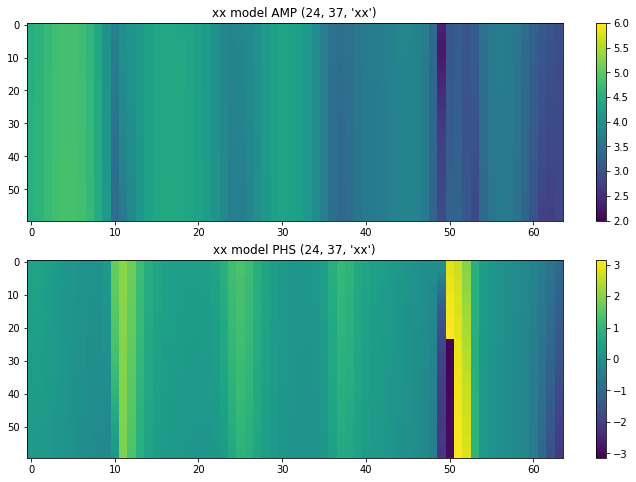

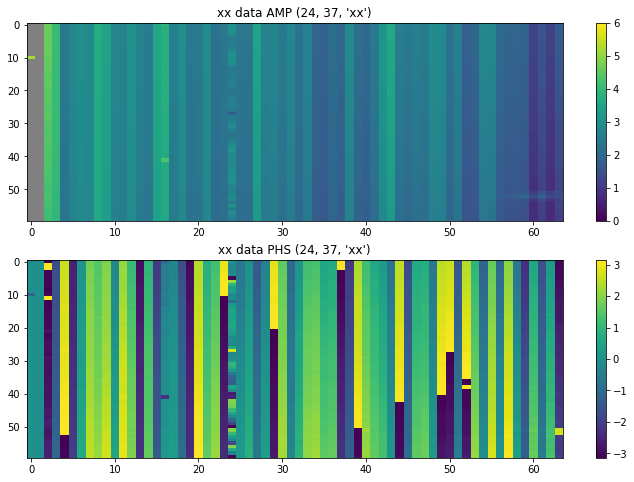

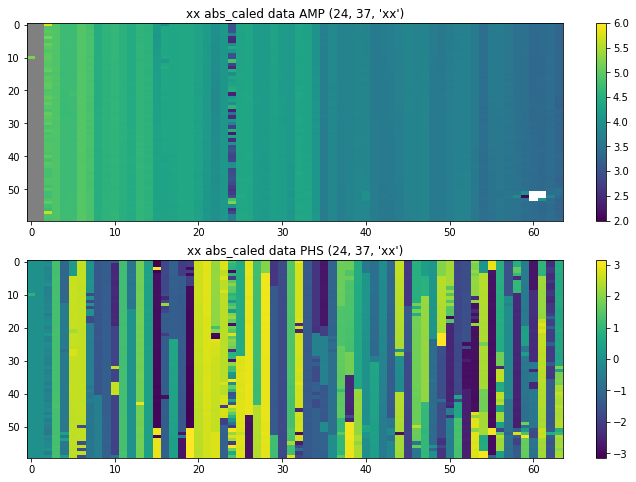

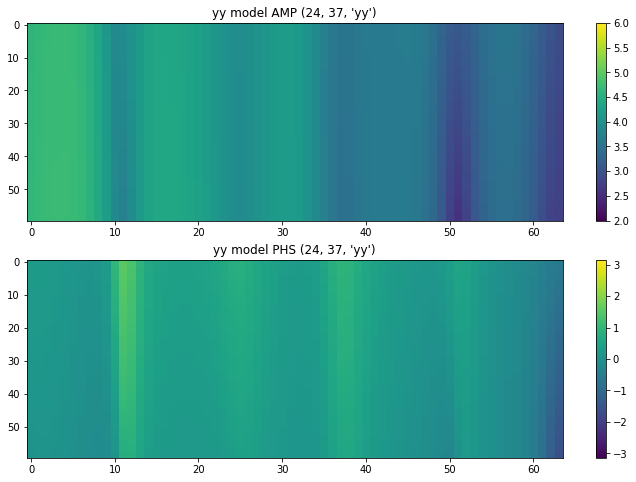

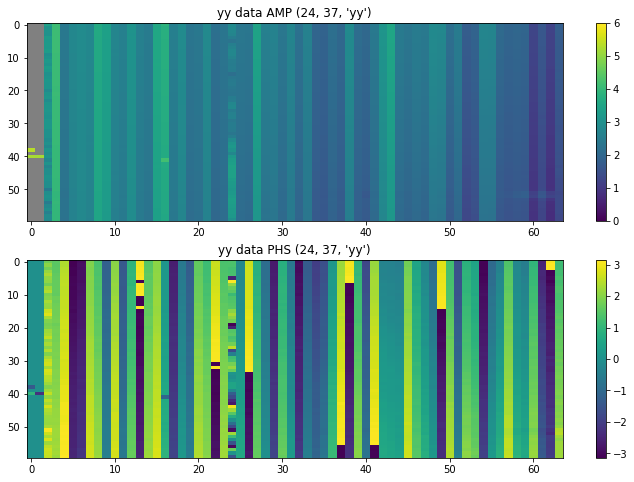

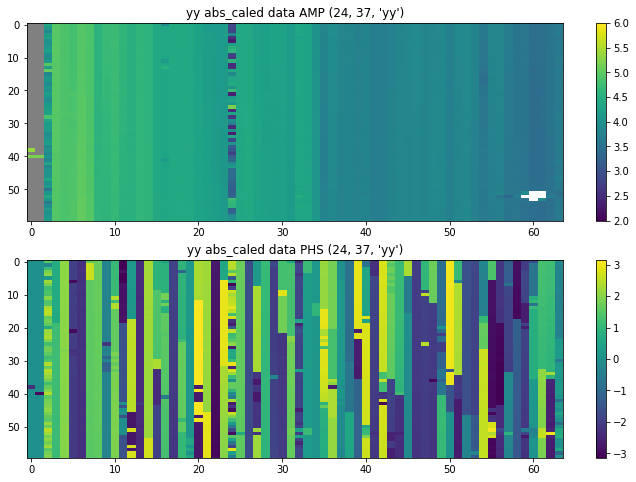

In [1062]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [1063]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [1064]:
#print noise['x']

In [1065]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 8945772.000MB


In [1066]:
##################### Delete or Erase Data #######################
Erase = False
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [1067]:
print Ni

[417.40415057+0.j 110.32946884+0.j 181.22845829+0.j ... 713.62504311+0.j
  21.22787894+0.j 111.28833367+0.j]


In [1068]:
# pre_ampcal = False

In [1069]:
#pre_ampcal = True

In [1070]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [0.23793901 0.20586156] yy [-0.23425251 -0.34959417]
>>>>>>>>>>>>>additive fitting amp [-0.05198124+0.j  0.0019343 +0.j] additive fraction 1.0705975886138912 pre process rephase xx [-0.16074769 -0.03192335] yy [-0.00345288  0.00328659]
>>>>>>>>>>>>>additive fitting amp [0.02938465+0.j 0.00225803+0.j] additive fraction 1.9465304583735206 pre process rephase xx [-0.00072601  0.00061706] yy [-0.00603132  0.00407633]
>>>>>>>>>>>>>additive fitting amp [0.03053743+0.j 0.00281332+0.j] additive fraction 0.04930213129406565 pre process rephase xx [-0.00084065  0.00066515] yy [-0.00448054  0.00394533]
>>>>>>>>>>>>>additive fitting amp [0.03182542+0.j 0.00335111+0.j] additive fraction 0.05011610785181747 pre process rephase xx [-0.00093126  0.000702  ] yy [-0.00278071  0.00281972]
>>>>>>>>>>>>>additive fitting amp [0.0332061 +0.j 0.00373141+0.j] additive fraction 0.04679939691726215 pre process rephase xx [-0.00100128  0.

>>>>>>>>>>>>>additive fitting amp [0.0485293 +0.j 0.00853389+0.j] additive fraction 0.031158643592982854 pre process rephase xx [-0.00137761  0.00099933] yy [-1.28741303e-07 -1.03731698e-07]
>>>>>>>>>>>>>additive fitting amp [0.04727763+0.j 0.00853393+0.j] additive fraction 0.0321999505697267 pre process rephase xx [-0.00135968  0.00099497] yy [-1.12543919e-07 -9.10747138e-08]
>>>>>>>>>>>>>additive fitting amp [0.04594798+0.j 0.00853395+0.j] additive fraction 0.03377236721682369 pre process rephase xx [-0.00137007  0.00100384] yy [-9.84032227e-08 -7.99398511e-08]
>>>>>>>>>>>>>additive fitting amp [0.04451702+0.j 0.00853398+0.j] additive fraction 0.03616500945630196 pre process rephase xx [-0.00135695  0.0010071 ] yy [-8.60539090e-08 -7.01489539e-08]
>>>>>>>>>>>>>additive fitting amp [0.0430091+0.j 0.008534 +0.j] additive fraction 0.0382105503345395 pre process rephase xx [-0.00133627  0.00100636] yy [-7.52659031e-08 -6.15437027e-08]
>>>>>>>>>>>>>additive fitting amp [0.0414372 +0.j 0.0

>>>>>>>>>>>>>additive fitting amp [0.0430769 +0.j 0.00853415+0.j] additive fraction 0.035384443762195614 pre process rephase xx [-0.00098444  0.00060806] yy [-3.69315388e-10 -3.09663897e-10]
>>>>>>>>>>>>>additive fitting amp [0.04163596+0.j 0.00853415+0.j] additive fraction 0.034756322523855084 pre process rephase xx [-0.00093914  0.00059078] yy [-3.23424839e-10 -2.71209348e-10]
>>>>>>>>>>>>>additive fitting amp [0.04022976+0.j 0.00853415+0.j] additive fraction 0.03465710998689535 pre process rephase xx [-0.00087258  0.00056592] yy [-2.83238552e-10 -2.37508885e-10]
>>>>>>>>>>>>>additive fitting amp [0.03889301+0.j 0.00853415+0.j] additive fraction 0.03367742247868674 pre process rephase xx [-0.00084737  0.00056705] yy [-2.48013776e-10 -2.07982520e-10]
>>>>>>>>>>>>>additive fitting amp [0.03756663+0.j 0.00853415+0.j] additive fraction 0.03420147687175624 pre process rephase xx [-0.00086084  0.0005841 ] yy [-2.17246609e-10 -1.82147570e-10]
>>>>>>>>>>>>>additive fitting amp [0.03619532+0.

>>>>>>>>>>>>>additive fitting amp [0.00596859+0.j 0.00853415+0.j] additive fraction 0.0017962170815486564 pre process rephase xx [5.33493008e-05 1.39686341e-04] yy [-1.06823511e-12 -9.07501202e-13]
>>>>>>>>>>>>>additive fitting amp [0.0059643 +0.j 0.00853415+0.j] additive fraction 0.0007274103639863042 [0.0059643 +0.j 0.00853415+0.j]
saving data to /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../simulate_visibilities/scripts/../Output/hera47hera47-150.000000-ampcal-_2018__2018__gsmcal_n32_bn64.npz


In [1071]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

578750.1413770125
2746.9744679241535
490013.22120103094
0.0047463910097513135

4451.142010550517
[-31905.30215356+0.j -32250.6419253 +0.j -32875.98600621+0.j ...
  10664.86382056+0.j  11148.81169788+0.j  11306.0734171 +0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905

In [1072]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.00596430015731475+0j) (0.008534152539916795+0j) 2
(0.00596430015731475+0j)
[[0.0059643 +0.j]
 [0.00853415+0.j]]
True


In [1073]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

578750.1413770125
2746.9744679241535
490013.22120103094
0.8466749054007123
4451.142010550517
[0.01484827+0.j 0.00392474+0.j 0.00644682+0.j ... 0.05197457+0.j
 0.00154606+0.j 0.00810533+0.j]
(3106.1299321377132+0j)
[ 8.20657848+0.j 15.96227339+0.j 12.45452907+0.j ...  4.38636288+0.j
 25.43233864+0.j 11.10746054+0.j]


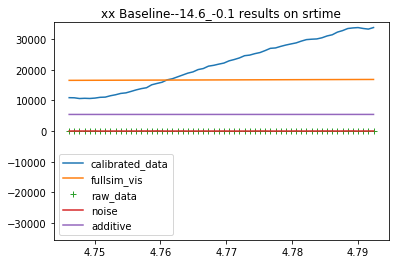

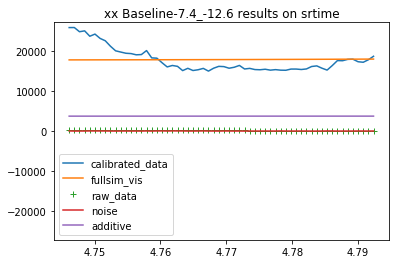

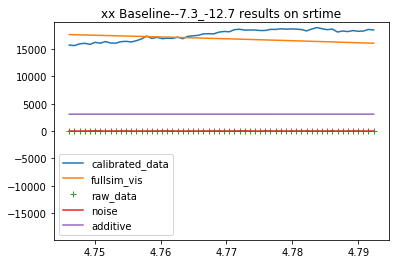

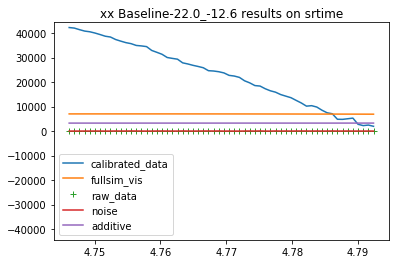

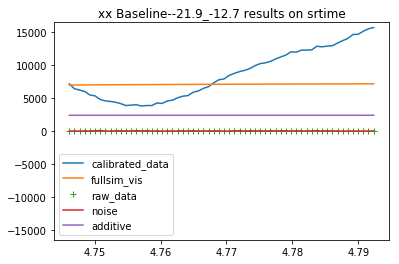

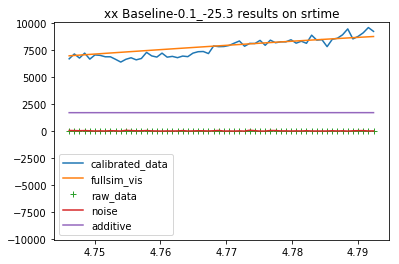

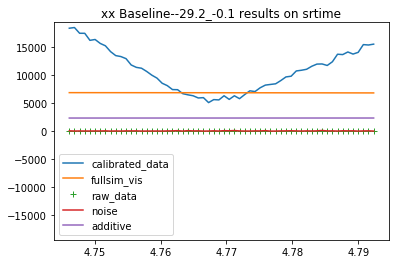

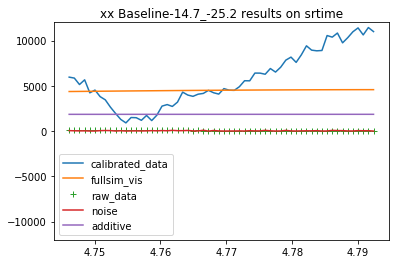

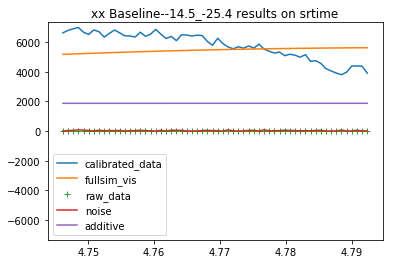

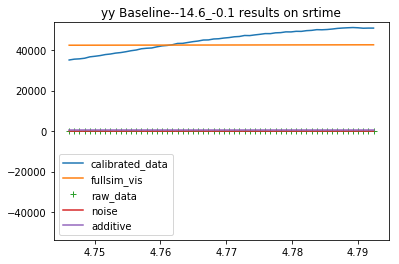

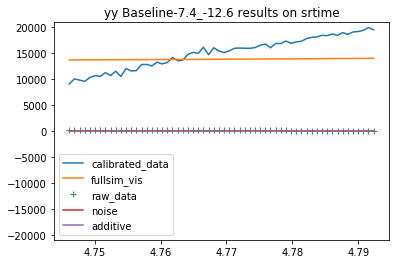

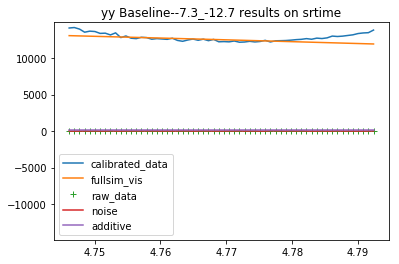

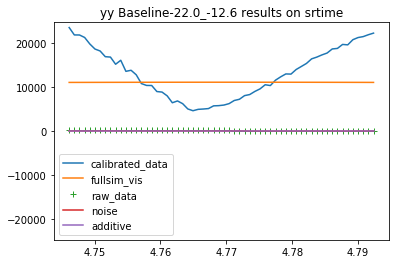

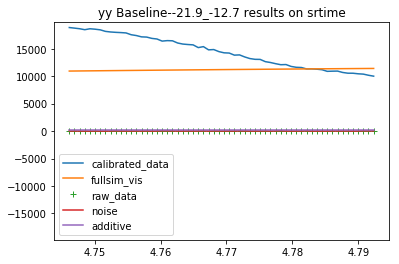

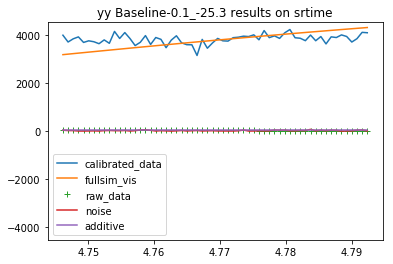

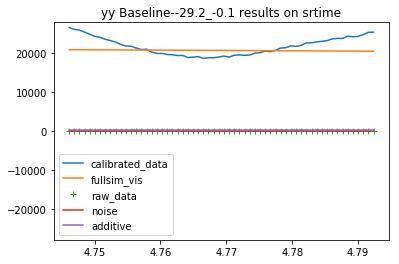

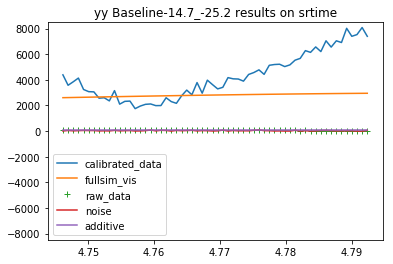

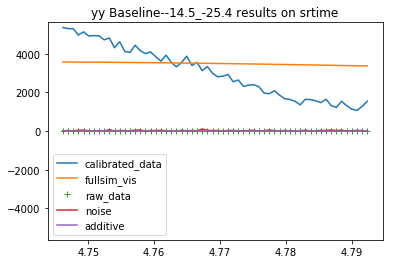

In [1074]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [1075]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [1076]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


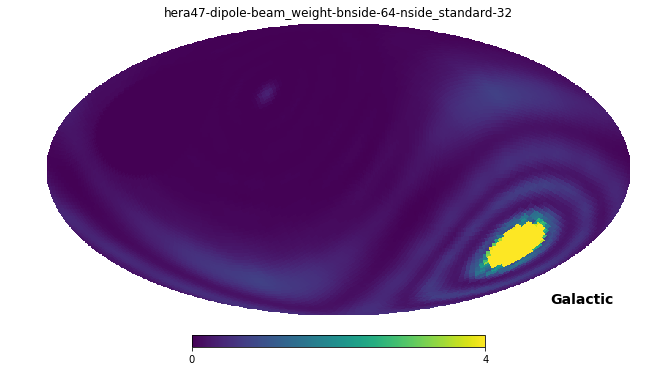

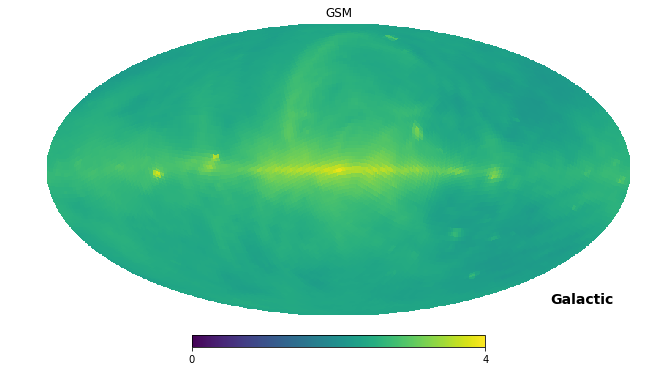

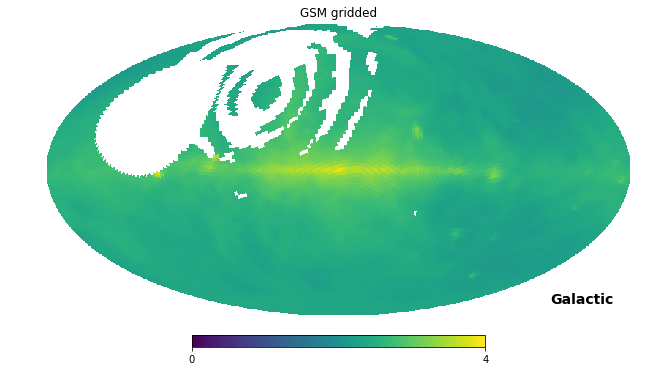

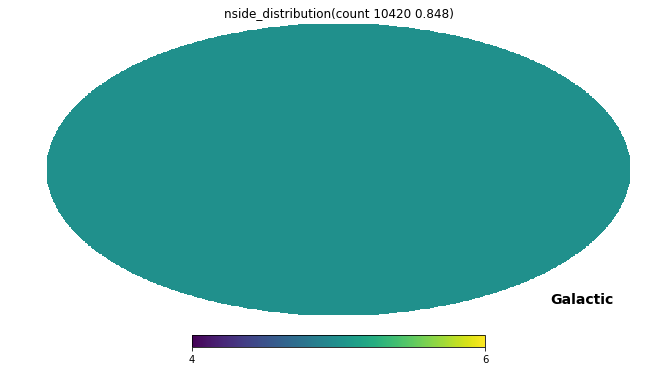

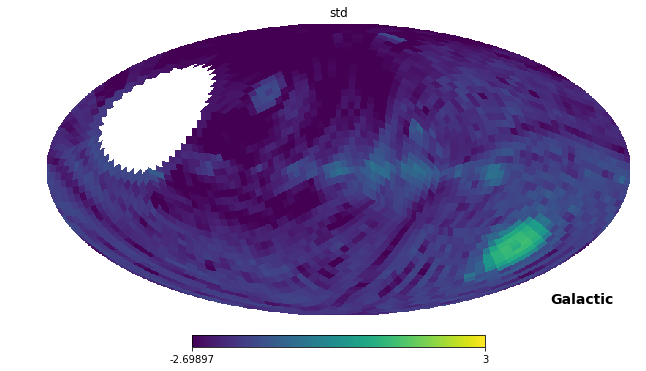

In [1077]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

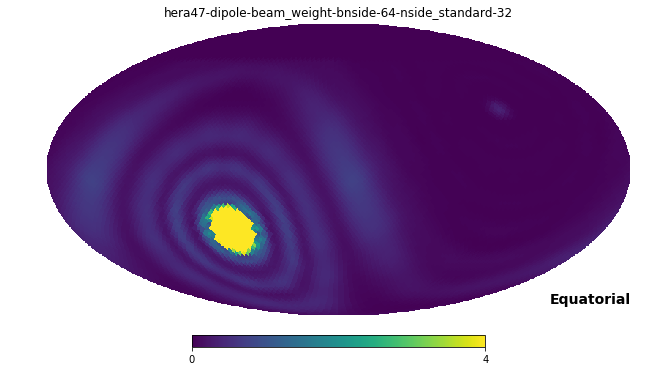

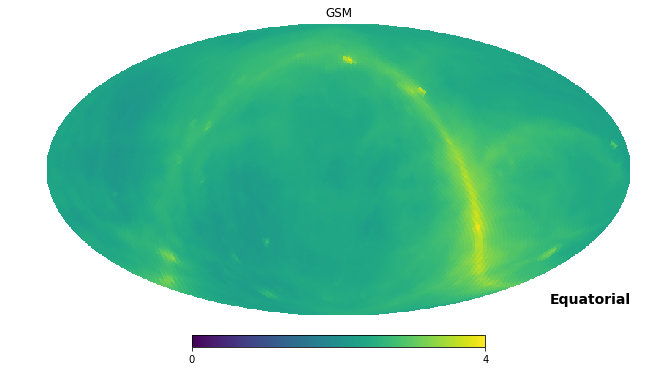

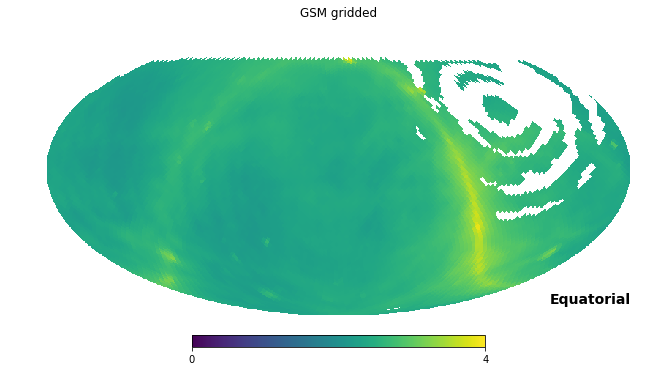

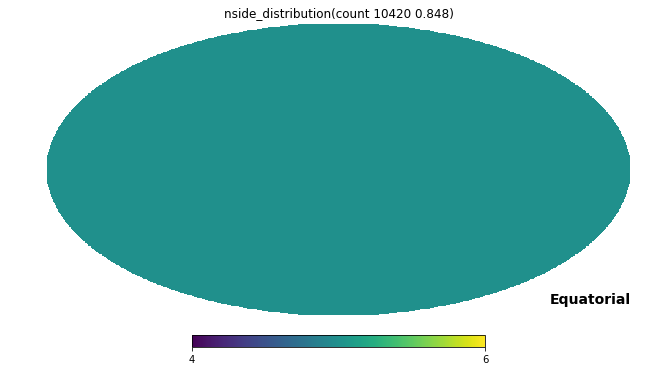

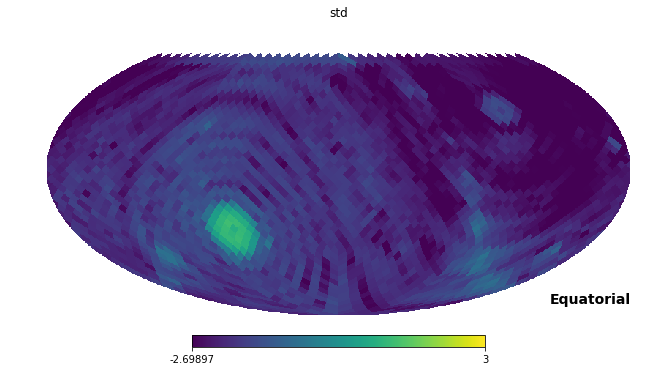

In [1078]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [1079]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.088498 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [1080]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [1081]:
Integration_Time
np.sum(Ni**-1)**.5

(1570.3728931777234+0j)

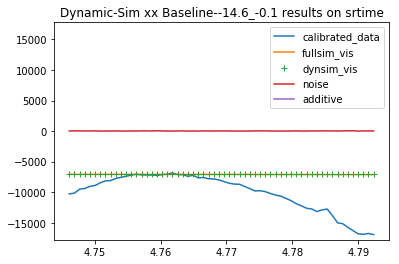

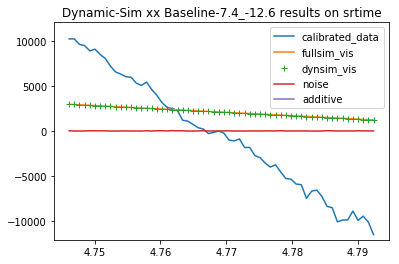

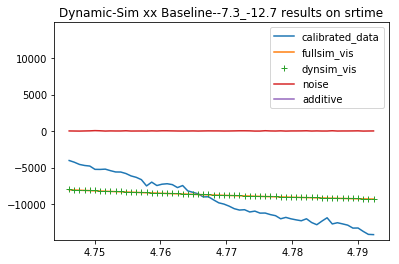

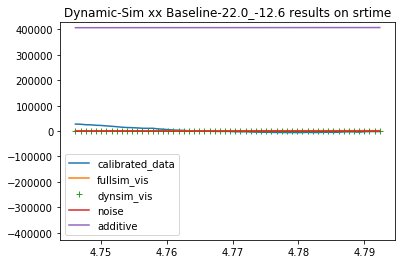

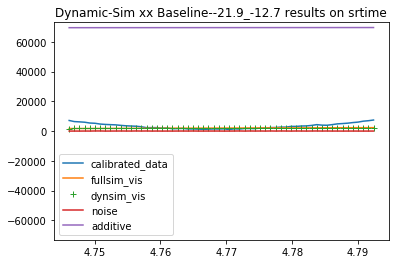

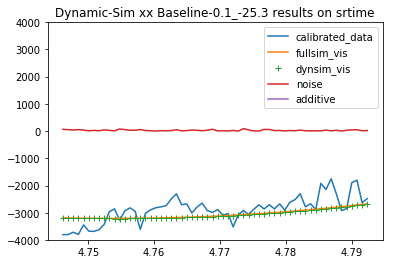

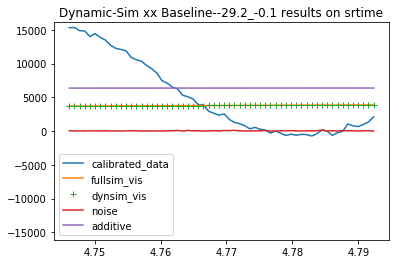

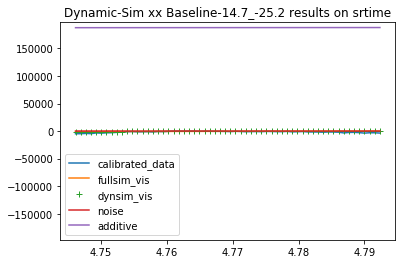

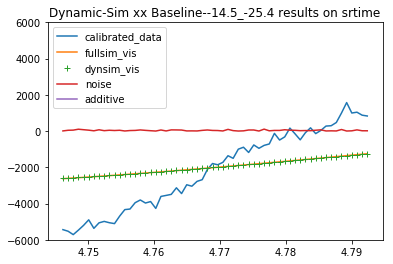

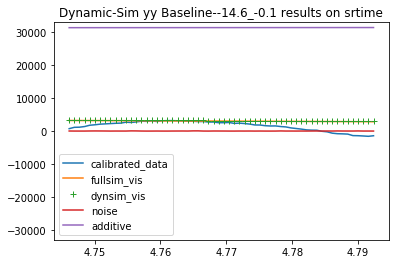

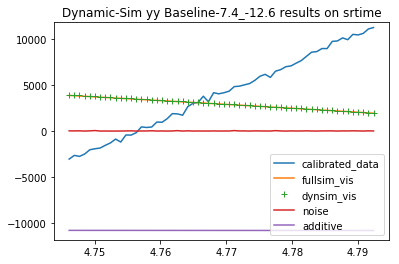

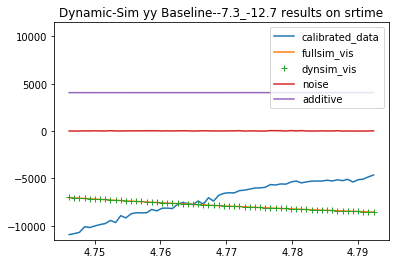

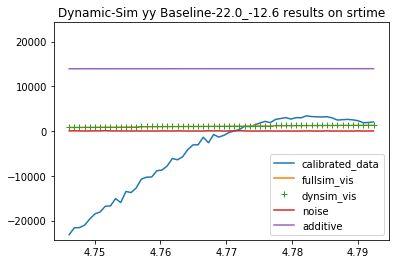

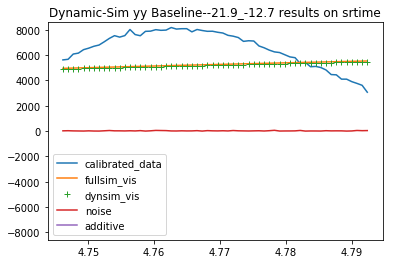

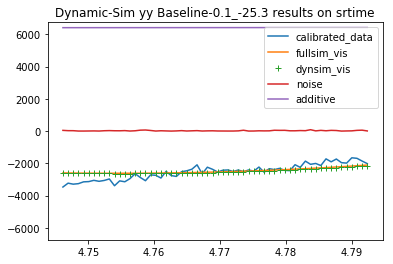

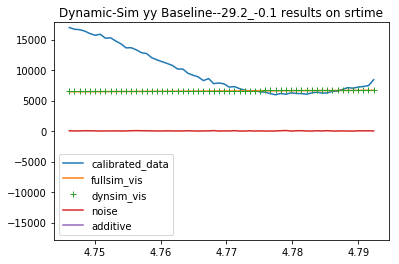

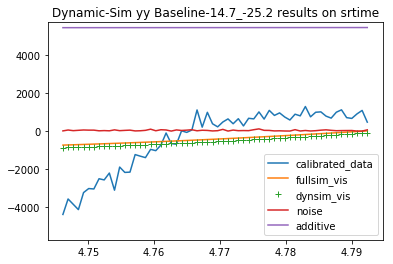

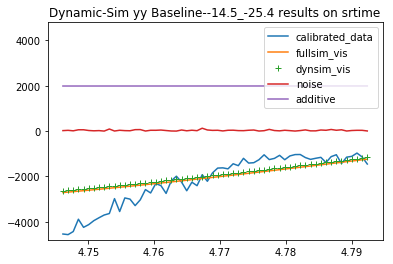

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (1.5431855906580292+0j)


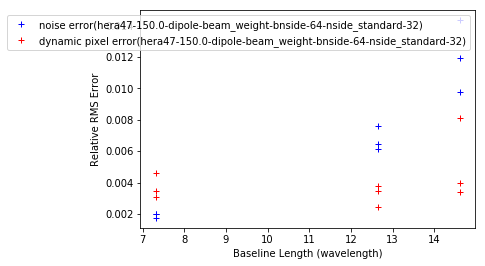

Normalization from visibilities 1.113466722503498


In [1082]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [1083]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [1084]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [1085]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000031 minutes used


In [1086]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
rcond_list = 10.**np.arange(-3., -0., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-08 02:53:38.704268
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.0mins 0.288995 minutes used
Computing Regularized AtNiAi, 2018-03-08 02:53:57.195503, expected time 1.0 min trying 0.001 0.394645 minutes used
regularization stength (0.0031206428319377243+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [1087]:
S_type
I_supress

1.0

Applying Regularized AtNiAi... Memory usage: 9160470.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../simulate_visibilities/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


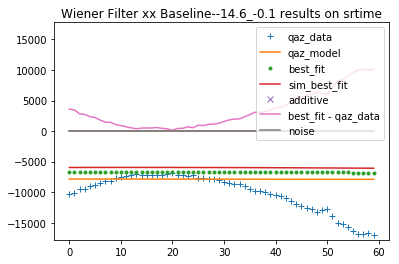

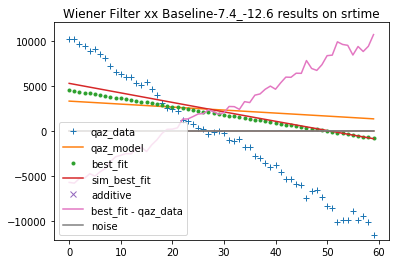

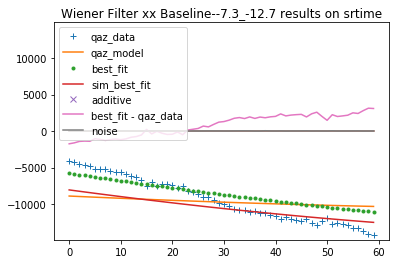

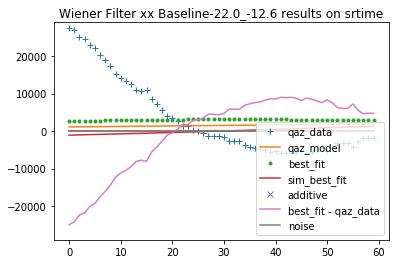

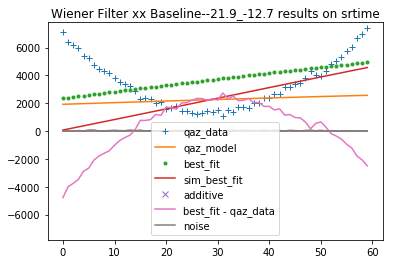

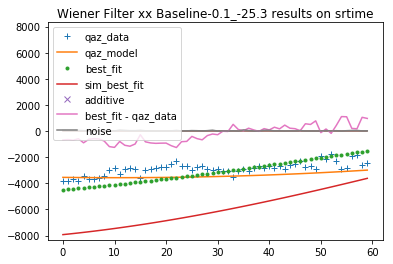

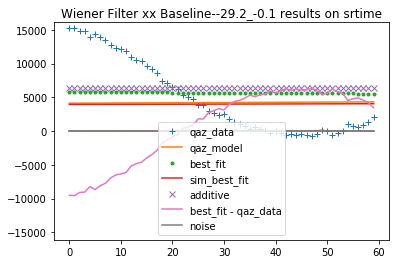

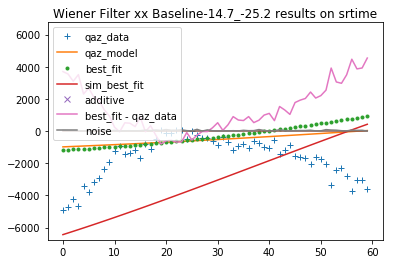

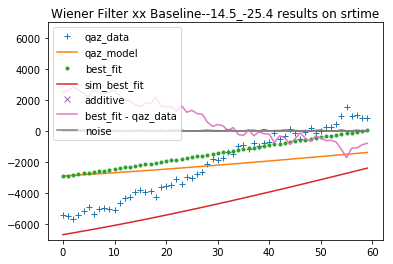

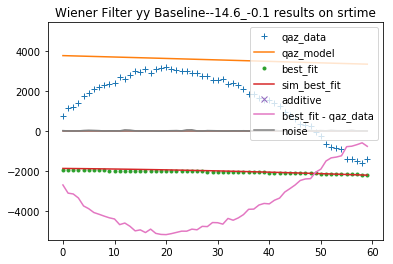

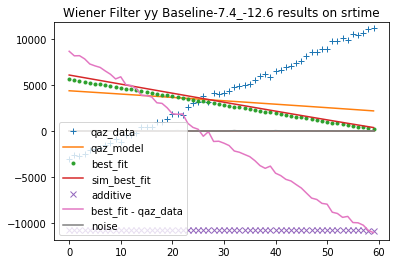

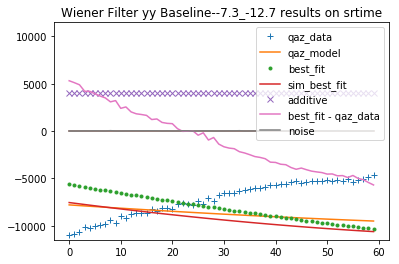

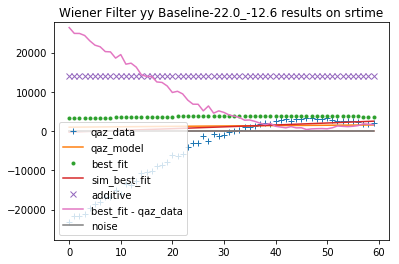

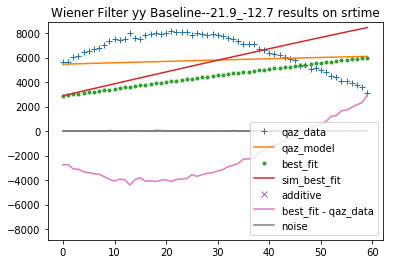

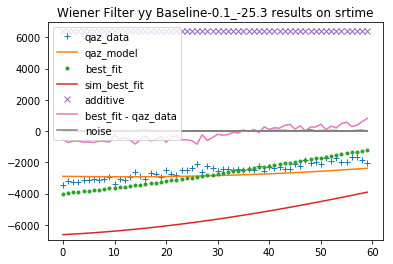

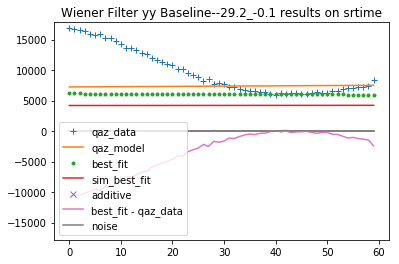

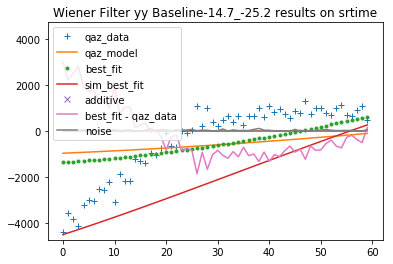

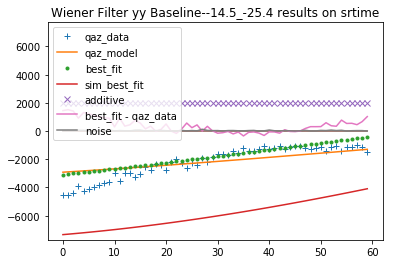

In [1088]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [1089]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [1090]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [1091]:
%matplotlib inline

In [1092]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5544
Number of Positive w_GSM Pixels: 5711
Number of Positive w_sim Pixels: 5838
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


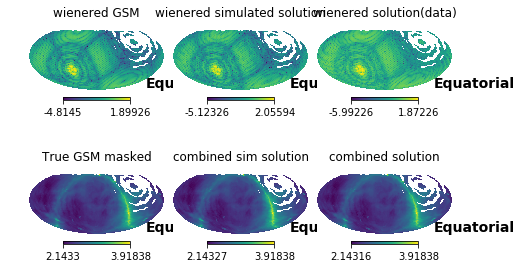

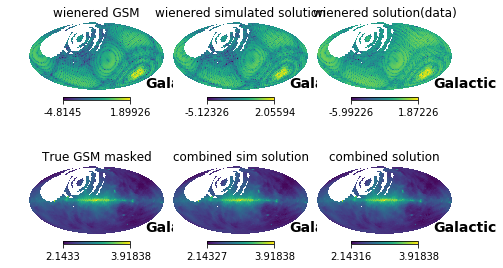

In [1093]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


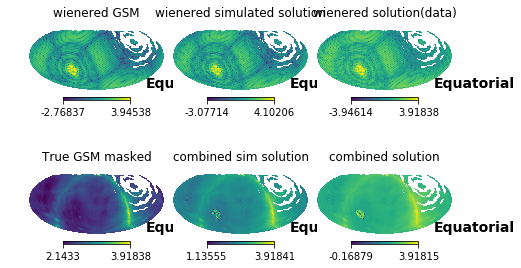

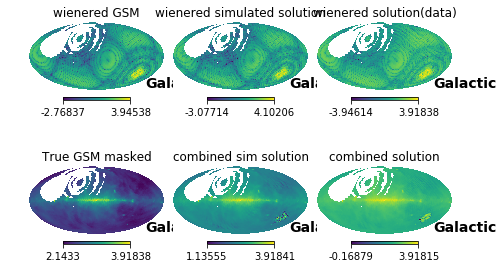

In [1094]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


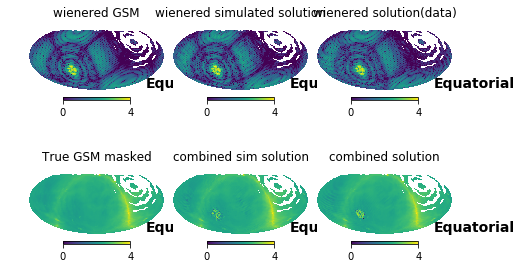

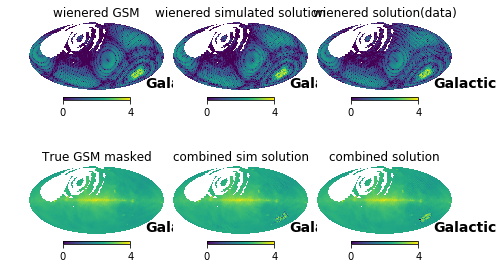

In [1095]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


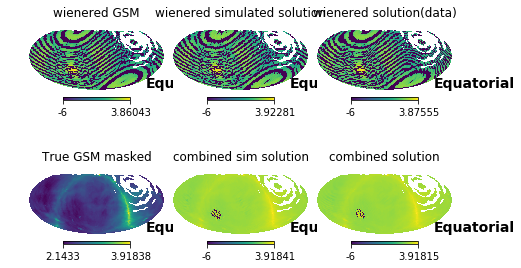

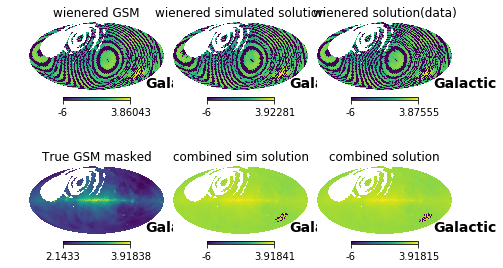

In [1096]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


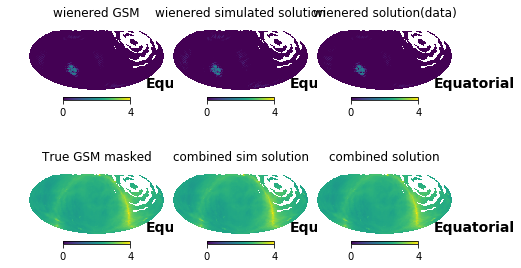

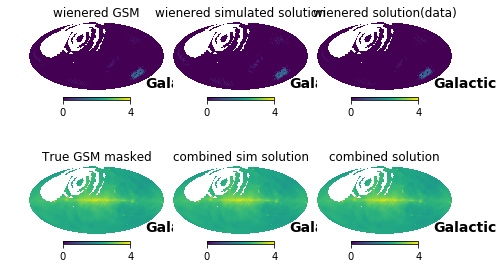

In [1097]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


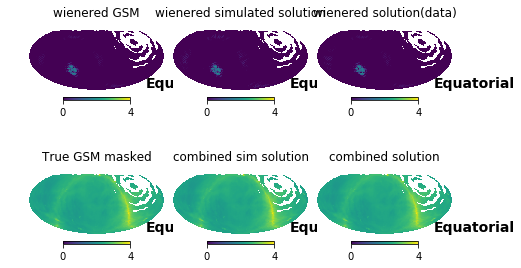

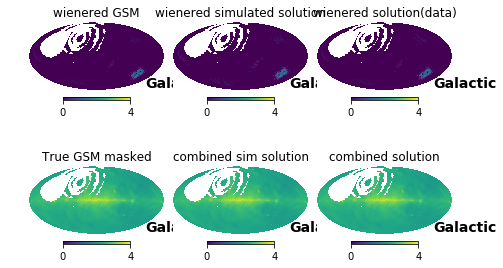

In [1098]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 2.138e+10, data points 2160, pixels 10420
re/im chi2 1.634e+10, 5.041e+09
xx/yy chi2 1.285e+10, 8.534e+09


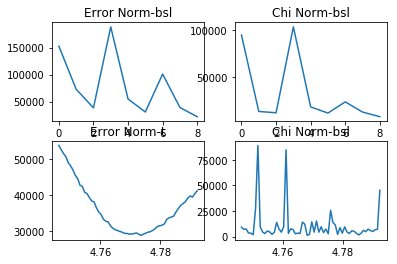

Additive_sol: [0.0059643 +0.j 0.00853415+0.j]
('regularization stength', (0.0031206428319377243+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 111.20465634622754


In [1099]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

In [1100]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [1101]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 -5.551115123125783e-17


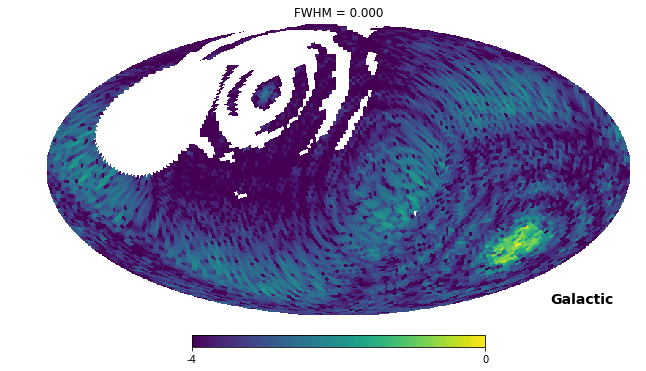

1.5707963267948966 3.5886741904258676e-18


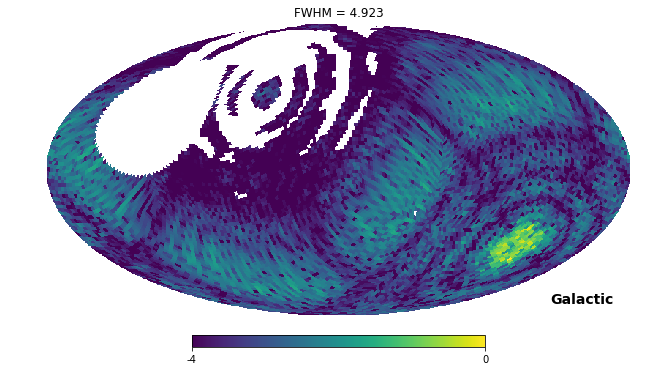

1.5707963267948966 -2.042149715731353e-17


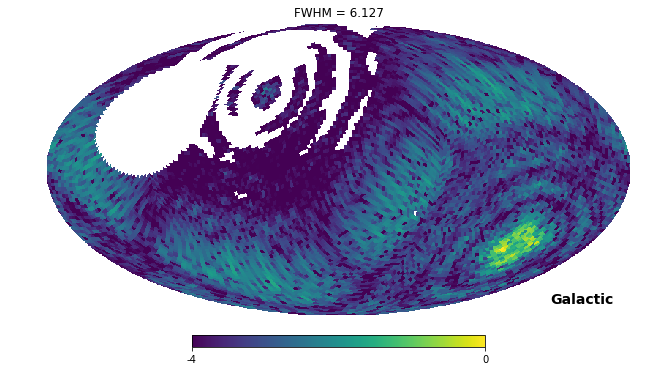

1.5707963267948966 -5.551115123125783e-17


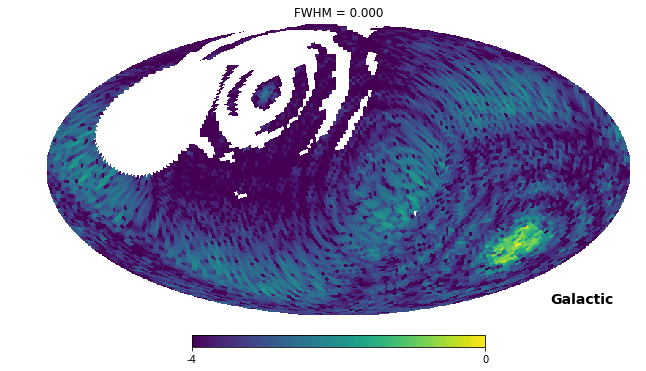

1.5707963267948966 6.2421462275232076e-18


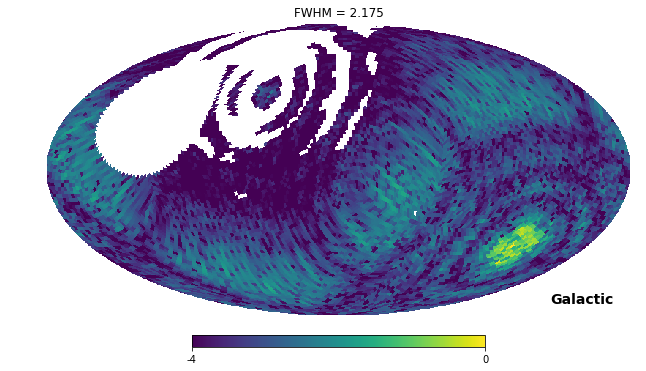

1.5707963267948966 -3.1689246296058633e-17


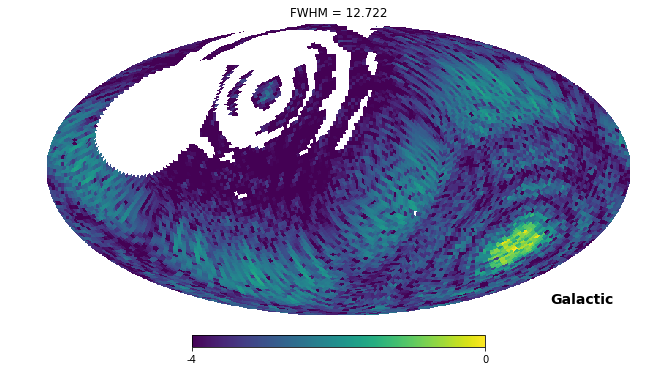

1.5707963267948966 1.2657715076548705e-17


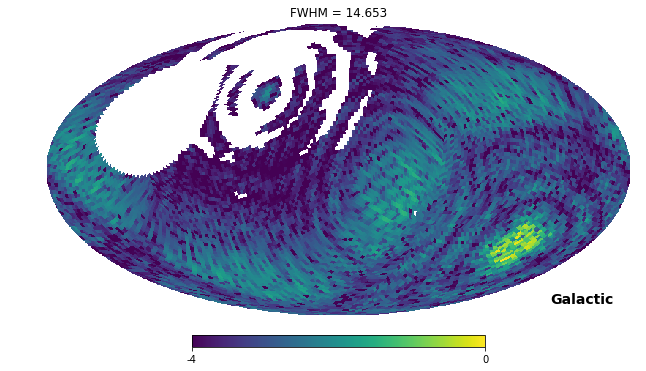

1.5707963267948966 -3.415498305426138e-17


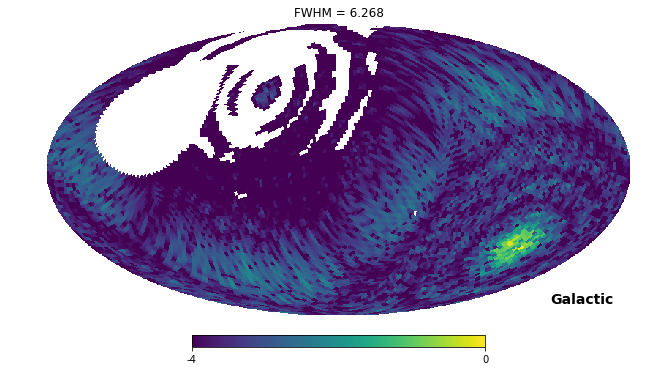

1.5707963267948966 -3.1689246296058633e-17


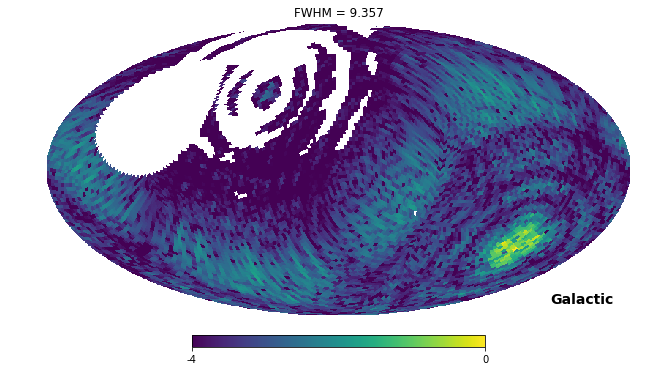

1.5707963267948966 -7.615484728191307e-18


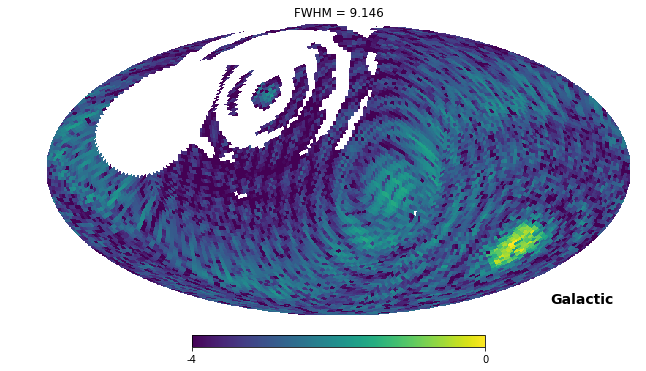

1.5707963267948966 7.423926927086674e-18


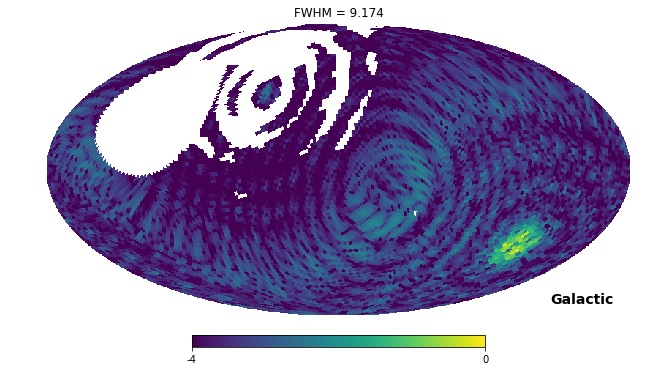

1.5707963267948966 0.0


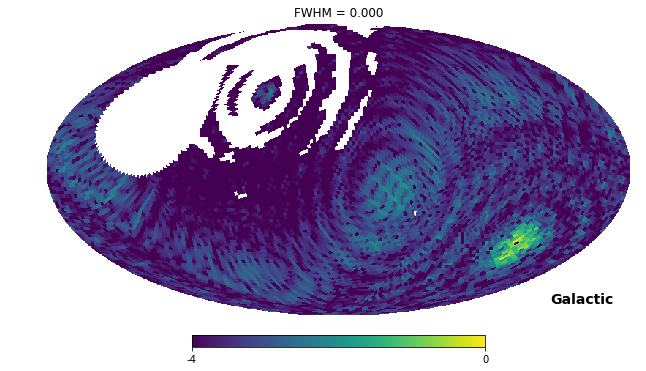

1.5707963267948966 -3.785290652650653e-18


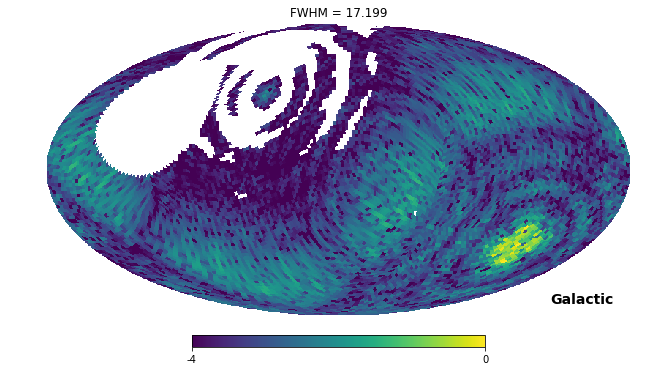

1.5707963267948966 -4.1897014905763103e-17


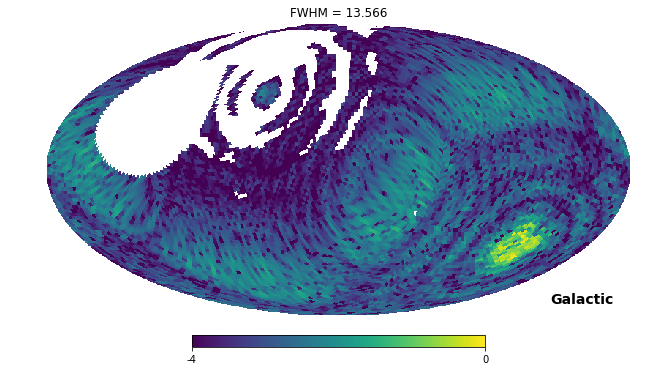

In [1102]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [1103]:
#point_vec